# 0.0 Set Up

In [ ]:
import tarfile
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

tar_file_path = '/content/drive/My Drive/datasets.tar'
json_files = 'datasets'  # Assuming 'datasets' is a folder inside the tar archive

try:
  with tarfile.open(tar_file_path, 'r') as tar_ref:
    tar_ref.extractall('/content/datasets')  # Extract to a temporary directory

  # Assuming 'datasets' is a folder containing your CSV file
  df = pd.read_csv(f'/content/datasets/{json_files}/your_csv_file.csv')
  # Replace 'your_csv_file.csv' with the actual file name

except FileNotFoundError:
  print(f"Error: File not found at {tar_file_path}")
except KeyError:
  print(f"Error: File or directory {json_files} not found inside the tar archive.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Mounted at /content/drive


## 1.0 Imports - !pip install <package_name> if necessary

In [ ]:
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')  # For lemmatization


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 0.1 Helper Functions

In [ ]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):
    """
    Creates TF-IDF matrix for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json)): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (TfidfVectorizer, optional): TfidfVectorizer object for vectorizing text data.
                                             Defaults to TfidfVectorizer().

    Returns:
    tuple: A tuple containing TF-IDF matrices for citing and non-citing patents respectively.
           (tfidf_matrix_citing, tfidf_matrix_nonciting)
    """
    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    # Since we're interested in similarities between citing and cited patents,
    # we need to split the TF-IDF matrix back into two parts
    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    # Size of vocabulary
    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting



def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

def create_corpus(corpus, text_type):
    """
    Extracts text data from a corpus based on the specified text type.

    Parameters:
    corpus (list): List of dictionaries representing patent documents.
    text_type (str): Type of text to extract ('title', 'abstract', 'claim1', 'claims', 'description', 'fulltext').

    Returns:
    list: List of dictionaries with 'id' and 'text' keys representing each document in the corpus.
    """

    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]

    cnt = 0 # count the number of documents without text
    texts = []  # list of texts
    ids_to_remove = []  # list of ids of documents without text, to remove them from the corpus

    if text_type == 'title':
        for doc in corpus:
            try:
                texts.append(doc['Content']['title'])
            except: # if the document does not have a title
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without title: {cnt}")

    elif text_type == 'abstract':
        for doc in corpus:
            try:
                texts.append(doc['Content']['pa01'])
            except: # if the document does not have an abstract
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without abstract: {cnt}")

    elif text_type == 'claim1':
        for doc in corpus:
            try:
                texts.append(doc['Content']['c-en-0001'])
            except: # if the document does not have claim 1
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without claim 1: {cnt}")

    elif text_type == 'claims':
        # all the values with the key starting with 'c-en-', each element in the final list is a list of claims
        for doc in corpus:
            doc_claims = []
            for key in doc['Content'].keys():
                if key.startswith('c-en-'):
                    doc_claims.append(doc['Content'][key])
            if len(doc_claims) == 0:    # if the document does not have any claims
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_claims)
                texts.append(doc_text_string)
        print(f"Number of documents without claims: {cnt}")

    elif text_type == 'description':
        # all the values with the key starting with 'p'
        for doc in corpus:
            doc_text = []
            for key in doc['Content'].keys():
                if key.startswith('p'):
                    doc_text.append(doc['Content'][key])
            if len(doc_text) == 0:  # if the document does not have any description
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without description: {cnt}")

    elif text_type == 'fulltext':
        for doc in corpus:
            doc_text = list(doc['Content'].values())
            doc_text_string = ' '.join(doc_text)
            texts.append(doc_text_string)
        if cnt > 0:
            print(f"Number of documents without any text: {cnt}")

    else:
        raise ValueError("Invalid text type")

    if len(ids_to_remove) > 0:
        print(f"Removing {len(ids_to_remove)} documents without required text")
        for id_ in ids_to_remove[::-1]:
            idx = app_ids.index(id_)
            del app_ids[idx]

    # Create a list of dictionaries with app_ids and texts
    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]

    return corpus_data


def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents (groud truth)
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents (predictions)

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping



def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks


def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks



def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision

def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks


# 1.0 Load Datasets

In [ ]:
json_citing_train = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("./datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("./datasets/Citation_JSONs/Citation_Train.json") # Citing ids are unique


In [ ]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)


In [ ]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content,Title
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...,DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...,TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION ...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...,LAUNDRY MACHINE AND CONTROL METHOD OF THE SAME
3,3611147,2020-02-19,A1,{'title': 'CHEMICAL AND TOPOLOGICAL SURFACE MO...,CHEMICAL AND TOPOLOGICAL SURFACE MODIFICATION ...
4,3640454,2020-04-22,A1,"{'title': 'FUEL METERING SYSTEM', 'pa01': 'The...",FUEL METERING SYSTEM
...,...,...,...,...,...
6826,3741587,2020-11-25,A1,{'title': 'AUTO-LOCATION USING TIRE MOUNTED SY...,AUTO-LOCATION USING TIRE MOUNTED SYSTEM
6827,3693248,2020-08-12,A1,{'title': 'HOLE COVER AND STEERING SYSTEM INCL...,HOLE COVER AND STEERING SYSTEM INCLUDING THE SAME
6828,3628962,2020-04-01,A1,{'title': 'SYSTEM AND METHOD FOR MEASURING CLE...,SYSTEM AND METHOD FOR MEASURING CLEARANCE GAPS...
6829,3620899,2020-03-11,A1,{'title': 'TOUCH SCREEN AND DISPLAY APPARATUS'...,TOUCH SCREEN AND DISPLAY APPARATUS


In [ ]:
print(citing_dataset_df.info())
print(citing_dataset_df.describe())
print(citing_dataset_df.columns)
print(citing_dataset_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Application_Number    6831 non-null   object
 1   Application_Date      6831 non-null   object
 2   Application_Category  6831 non-null   object
 3   Content               6831 non-null   object
 4   Title                 6831 non-null   object
dtypes: object(5)
memory usage: 267.0+ KB
None
       Application_Number Application_Date Application_Category  \
count                6831             6831                 6831   
unique               6829               53                    2   
top               3621312       2020-06-24                   A1   
freq                    2              262                 6829   

                                                  Content           Title  
count                                                6831            6831  
unique   

In [ ]:
nonciting_dataset_df


,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...","Synchronization of a split audio, video, or ot..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,Fluid handling unit and fluid handling apparat...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",Oil pump system for vehicle
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,Apparatus for construction of quasi orthogonal...


In [ ]:
print(nonciting_dataset_df.info())
print(nonciting_dataset_df.describe())
print(nonciting_dataset_df.columns)
print(nonciting_dataset_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16837 entries, 0 to 16836
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Application_Number    16837 non-null  object
 1   Application_Date      16837 non-null  object
 2   Application_Category  16837 non-null  object
 3   Content               16837 non-null  object
 4   Title                 16837 non-null  object
dtypes: object(5)
memory usage: 657.8+ KB
None
       Application_Number Application_Date Application_Category  \
count               16837            16837                16837   
unique              16807              539                    6   
top               1791164       2013-02-27                   B1   
freq                    2               99                 7932   

                                                  Content           Title  
count                                               16837           16837  
unique 

In [ ]:
mapping_dataset_df

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A
...,...,...,...,...,...
8589,3623977A1,"[c-en-0008, c-en-0009, c-en-0010, c-en-0011, c...",2518981A1,"[p0021, p0022, p0023, p0024, p0025, p0026, p00...",A
8590,3721843A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3213727A1,"[p0015, p0016, p0017, p0018, p0019, p0020, p00...",X
8591,3708263A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3217171A1,"[pa01, p0010, p0014, p0003, p0009, p0016]",A
8592,3588557A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",2988328A1,"[p0047, p0012]",A


In [ ]:
mapping_dict = get_mapping_dict(mapping_dataset_df)
mapping_dict


{'3712070A1': ['3354576A1'],
 '3675165A1': ['3336831A2'],
 '3599626A1': ['2453448A1'],
 '3705201A1': ['2468433A2'],
 '3628210A1': ['3369366A1'],
 '3637504A1': ['2482368A1'],
 '3758169A1': ['2575411A1'],
 '3597767A1': ['2226127A1'],
 '3588532A1': ['2879156A1'],
 '3670817A1': ['3231978A1'],
 '3702079A1': ['3338931A1'],
 '3668068A1': ['3116204A1'],
 '3750631A1': ['3132851A1'],
 '3599082A1': ['2730353A1'],
 '3587089A1': ['3028845A1'],
 '3605854A1': ['3319239A1'],
 '3607862A1': ['2815685A1'],
 '3742402A1': ['3361724A2'],
 '3705896A1': ['2743710A1'],
 '3587065A1': ['2689910A1'],
 '3739813A1': ['2584496A1'],
 '3624050A1': ['2887642A2'],
 '3719445A1': ['2778606A1'],
 '3599363A1': ['3486467A2'],
 '3747742A1': ['2783951A1'],
 '3742709A1': ['3101560A1'],
 '3667442A1': ['2808242A1'],
 '3670124A1': ['2826608A1'],
 '3715223A1': ['2815953A1'],
 '3686680A1': ['3435167A1'],
 '3723272A1': ['3076542A1'],
 '3674167A1': ['2447130A1'],
 '3689738A1': ['3263446A1'],
 '3606117A1': ['3267699A1'],
 '3670347A1': 

In [ ]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

## Comments:

Let’s analyze your datasets based on the outputs you’ve shared. Here’s a structured breakdown:

---

### **1. `citing_dataset_df` (Citing Patents – Queries)**
- **Size**: 6,831 patents (rows).  
- **Columns**:  
  - `Application_Number`: Unique ID for citing patents (e.g., `3597545A1`).  
  - `Application_Date`: Dates in 2020 (matches the dataset name "Citing_2020").  
  - `Application_Category`: Mostly `A1` (patent type).  
  - `Content`: Nested JSON with patent text sections (title, claims, descriptions, etc.).  

#### **Key Observations**:
- **Duplicate Application Numbers**:  
  `Application_Number` has 6,829 unique values but 6,831 rows → **2 duplicates**.  
  Example: `3621312` appears twice. This could cause issues (e.g., ambiguous queries).  
- **Text Extraction**:  
  The `Content` field contains structured text (e.g., `title`, `pa01` [likely abstract], `c-en-0001` [claim 1], etc.).  
  Use `create_corpus()` to extract specific text types (e.g., `text_type='abstract'`).  

---

### **2. `nonciting_dataset_df` (Cited/Uncited Patents – Corpus)**
- **Size**: 16,837 patents (rows).  
- **Columns**: Same structure as `citing_dataset_df`.  
- **Time Range**:  
  - `Application_Date` spans 2010–2019 (matches "Cited_2020_Uncited_2010-2019").  
  - Includes **cited patents** (ground truth) and **uncited patents** (distractors).  

#### **Key Observations**:
- **Application Categories**:  
  Mostly `B1` (7,932 entries) and `A1/A2`. Categories may indicate patent types or jurisdictions.  
- **Potential Noise**:  
  `Content` for some patents may be incomplete (e.g., missing claims or descriptions).  
  Use `create_corpus()` to filter out patents with missing text (e.g., `text_type='claims'`).  

---

### **3. `mapping_dataset_df` (Gold Mapping)**
- **Size**: 8,594 rows (citing-to-cited pairs).  
- **Structure**:  
  - Column `0`: Citing patent ID (e.g., `3712070A1`).  
  - Column `2`: Cited patent ID (e.g., `3354576A1`).  
  - Other columns (1, 3, 4): Likely metadata (e.g., claim numbers or paragraphs where citations appear).  

#### **Key Observations**:
- **Mapping Completeness**:  
  The resulting `mapping_dict` has ~8,594 entries (assuming no duplicates in column `0`).  
  Example: `{"3712070A1": ["3354576A1"], ...}`.  
- **Implications for Evaluation**:  
  Each citing patent in `citing_dataset_df` may have 1+ cited patents in `nonciting_dataset_df`.  

---

### **4. Critical Insights for Your Project**
#### **(a) Data Challenges**
- **Duplicate IDs**:  
  - `citing_dataset_df` has 2 duplicate `Application_Number`s. Resolve these (e.g., drop duplicates).  
- **Text Completeness**:  
  - Some patents in `nonciting_dataset_df` might lack claims/descriptions. Use `create_corpus()` to filter them out.  
- **Temporal Consistency**:  
  - Citing patents are from **2020**, while cited/uncited patents are from **2010–2019** (as expected for prior art).  

#### **(b) Evaluation Setup**
- **Ground Truth**: `mapping_dict` defines true cited patents for each query.  
- **Corpus Size**: 16,837 patents → A **retrieval task with moderate scale** (top-100 from ~16k candidates).  

#### **(c) Text Extraction Strategy**
- **Best Fields for Retrieval**:  
  - `title` is short but may lack detail.  
  - `claims` or `description` are richer but longer.  
  - Experiment with `text_type` in `create_corpus()` to see which performs best (e.g., `abstract` vs. `claims`).  

---

### **5. Next Steps**
1. **Resolve Duplicates**:  
   ```python
   citing_dataset_df.drop_duplicates(subset=["Application_Number"], inplace=True)
   ```
2. **Extract Text**:  
   ```python
   citing_corpus = create_corpus(json_citing_train, text_type="abstract")
   nonciting_corpus = create_corpus(json_nonciting, text_type="abstract")
   ```
3. **Validate Mapping**:  
   Ensure all cited patents in `mapping_dict` exist in `nonciting_dataset_df` (to avoid missing ground truth).  

Let me know if you’d like help with any of these steps!

## 1.1 Take a look at the content

In [ ]:
nonciting_dataset_df.loc[0].Content

{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',
 'c-en-0001': 'A vehicle support assembly, comprising: first and second tilting wheels (421A, 421B; 16, 16) disposed respectively at different lateral positions with respect to a longitudinal axis; a tilt-mechanism (431; 17) configured for supportively associating a vehicle body (402) from the tilting wheels (421A, 421B; 16, 16) to enable the vehicle body (402) to tilt substantially through a first tilt range with respect to a surface (428) on which the tilting wheels (421A, 421B; 16, 16) are disposed; a tilt-limiter (450, 550, 650) operably associated with the tilt-mechanism (431) to restrict the tilting of the vehicle body (402) to less than the first tilt range, and releasable to allow the tilting through the first tilt range; characterised in that the vehicle support assembly further comprises : an inclination sensor configured to sense an inclination of the vehicle (130, 430) with respect to the vertical at least when the vehicle is a

## 1.2 Create a column with the Title

Note for lateR: Try all text content by uncommenting the below

In [ ]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

In [ ]:
def extract_title(dictionary):
    return dictionary.get('title', None)  # Return None if 'title' key is not present

nonciting_dataset_df['Title'] = nonciting_dataset_df['Content'].apply(extract_title)
citing_dataset_df['Title'] = citing_dataset_df['Content'].apply(extract_title)

nonciting_dataset_df


,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...","Synchronization of a split audio, video, or ot..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,Fluid handling unit and fluid handling apparat...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",Oil pump system for vehicle
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,Apparatus for construction of quasi orthogonal...


# 1.3 Average title length

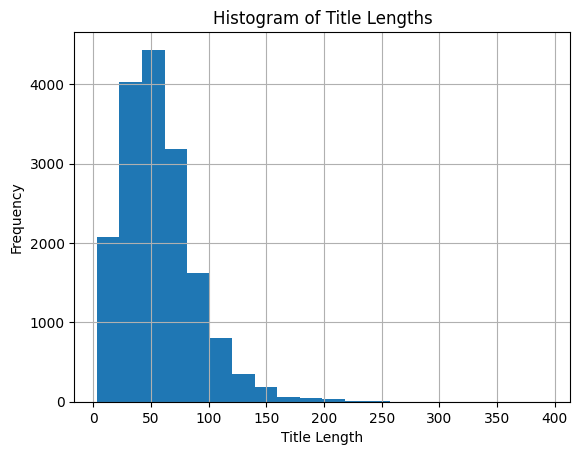

In [ ]:
plt.hist(nonciting_dataset_df['Title'].str.len(), bins=20)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')
plt.grid(True)
plt.show()

In [ ]:
# Compute histogram data
title_lengths = nonciting_dataset_df['Title'].str.len()
counts, bin_edges = np.histogram(title_lengths, bins=20)

# Print the results
for i in range(len(bin_edges) - 1):
    print(f"Bin {i+1}: {bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}, Frequency: {counts[i]}")


Bin 1: 3.0 - 22.6, Frequency: 2080
Bin 2: 22.6 - 42.1, Frequency: 4024
Bin 3: 42.1 - 61.7, Frequency: 4435
Bin 4: 61.7 - 81.2, Frequency: 3184
Bin 5: 81.2 - 100.8, Frequency: 1624
Bin 6: 100.8 - 120.3, Frequency: 802
Bin 7: 120.3 - 139.8, Frequency: 353
Bin 8: 139.8 - 159.4, Frequency: 181
Bin 9: 159.4 - 179.0, Frequency: 64
Bin 10: 179.0 - 198.5, Frequency: 43
Bin 11: 198.5 - 218.1, Frequency: 28
Bin 12: 218.1 - 237.6, Frequency: 6
Bin 13: 237.6 - 257.1, Frequency: 8
Bin 14: 257.1 - 276.7, Frequency: 2
Bin 15: 276.7 - 296.2, Frequency: 0
Bin 16: 296.2 - 315.8, Frequency: 1
Bin 17: 315.8 - 335.4, Frequency: 1
Bin 18: 335.4 - 354.9, Frequency: 0
Bin 19: 354.9 - 374.4, Frequency: 0
Bin 20: 374.4 - 394.0, Frequency: 1


## 1.3 Number of CITED patents per citing patent

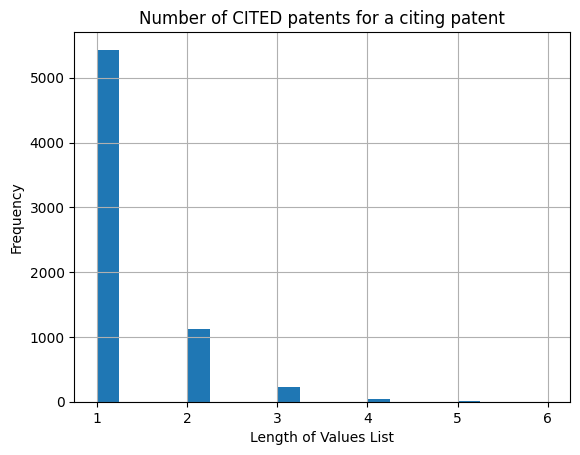

In [ ]:
list_lengths = [len(values) for values in mapping_dict.values()]

plt.hist(list_lengths, bins=20)
plt.xlabel('Length of Values List')
plt.ylabel('Frequency')
plt.title('Number of CITED patents for a citing patent')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Compute list lengths
list_lengths = [len(values) for values in mapping_dict.values()]

# Compute histogram data
counts, bin_edges = np.histogram(list_lengths, bins=20)

# Print the results
for i in range(len(bin_edges) - 1):
    print(f"Bin {i+1}: {bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}, Frequency: {counts[i]}")


Bin 1: 1.0 - 1.2, Frequency: 5433
Bin 2: 1.2 - 1.5, Frequency: 0
Bin 3: 1.5 - 1.8, Frequency: 0
Bin 4: 1.8 - 2.0, Frequency: 0
Bin 5: 2.0 - 2.2, Frequency: 1116
Bin 6: 2.2 - 2.5, Frequency: 0
Bin 7: 2.5 - 2.8, Frequency: 0
Bin 8: 2.8 - 3.0, Frequency: 0
Bin 9: 3.0 - 3.2, Frequency: 220
Bin 10: 3.2 - 3.5, Frequency: 0
Bin 11: 3.5 - 3.8, Frequency: 0
Bin 12: 3.8 - 4.0, Frequency: 0
Bin 13: 4.0 - 4.2, Frequency: 44
Bin 14: 4.2 - 4.5, Frequency: 0
Bin 15: 4.5 - 4.8, Frequency: 0
Bin 16: 4.8 - 5.0, Frequency: 0
Bin 17: 5.0 - 5.2, Frequency: 15
Bin 18: 5.2 - 5.5, Frequency: 0
Bin 19: 5.5 - 5.8, Frequency: 0
Bin 20: 5.8 - 6.0, Frequency: 3


## Comments:

Let’s break down the teacher’s analysis and identify additional steps to optimize your TF-IDF/BM25 rankings:

---

### **1. Teacher’s Analysis Summary**
#### **(a) Title Length Distribution (Non-Citing Patents)**
- **Observation**:  
  Most titles are **22–81 characters long**, with a few outliers up to ~394 characters.  
- **Implications**:  
  - Short titles may lack context (e.g., "FILM WRAPPING DISPLAY"), requiring reliance on other fields (e.g., claims/abstracts).  
  - Long titles may include technical jargon or redundancy (e.g., "METHOD AND APPARATUS FOR..."), which could dilute TF-IDF term weights.  

#### **(b) Number of Cited Patents per Citing Patent**
- **Observation**:  
  - **5433 citing patents (63%)** reference **1 cited patent**.  
  - **1116 citing patents** reference **2 cited patents**, and a few reference up to **6**.  
- **Implications**:  
  - Focus on **high recall@100** for queries with multiple true cited patents.  
  - For queries with 1 cited patent, **mean inverse rank** is critical (ensure the single true patent ranks high).  

---

### **2. Additional Analyses for TF-IDF/BM25 Optimization**
To improve retrieval performance, conduct these analyses:

#### **(a) Term Frequency Analysis**
- **Goal**: Identify common terms (e.g., stopwords, legal phrases) that may dominate TF-IDF/BM25 scores.  
- **Steps**:  
  1. Extract all terms from titles/abstracts/claims.  
  2. Plot term frequency distributions (log-scale).  
  3. Check for patent-specific stopwords (e.g., "method", "system", "apparatus").  
- **Impact**:  
  - Add domain-specific stopwords to the vectorizer.  
  - Adjust `max_df`/`min_df` in `TfidfVectorizer` to filter overly common/rare terms.  

#### **(b) Document Length Distribution**
- **Goal**: Understand how patent text length varies (BM25 penalizes long documents).  
- **Steps**:  
  1. Use `create_corpus(text_type='abstract')` (or `claims`/`description`).  
  2. Plot histogram of document lengths (word count).  
- **Impact**:  
  - Tune BM25 parameters (e.g., `k1`, `b`) if document lengths vary widely.  
  - Example: If abstracts are short, use smaller `b`; for long descriptions, increase `b`.  

#### **(c) Vocabulary Overlap Between Citing and Cited Patents**
- **Goal**: Check if query and corpus patents share vocabulary (critical for sparse retrieval).  
- **Steps**:  
  1. Compare term distributions:  
     - Unique terms in citing patents vs. nonciting patents.  
     - Overlap % (shared terms / total terms).  
  2. Analyze bigrams/trigrams (e.g., "solar panel efficiency" vs. "photovoltaic cell").  
- **Impact**:  
  - If overlap is low, use **stemming** or **lemmatization** (e.g., "efficiency" → "efficien").  
  - Use `ngram_range=(1,3)` in vectorizers to capture technical phrases.  

#### **(d) Text Field Importance**
- **Goal**: Determine which text field (title/abstract/claims) contains the most discriminative terms.  
- **Steps**:  
  1. Run separate TF-IDF experiments for `title`, `abstract`, and `claims`.  
  2. Compare evaluation metrics (e.g., Recall@100).  
- **Impact**:  
  - Combine fields (e.g., `title + claims`) if performance improves.  

#### **(e) Duplicate/Highly Similar Patents**
- **Goal**: Check for near-duplicate patents that could skew rankings.  
- **Steps**:  
  1. Compute pairwise cosine similarities between all corpus patents.  
  2. Flag patents with similarity > threshold (e.g., 0.95).  
- **Impact**:  
  - Deduplicate the corpus to avoid redundant retrievals.  

#### **(f) Temporal Analysis**
- **Goal**: Check if older patents (e.g., 2010) use outdated terminology vs. newer ones (2019).  
- **Steps**:  
  1. Group nonciting patents by `Application_Date` (year).  
  2. Track term usage over time (e.g., "blockchain" vs. "distributed ledger").  
- **Impact**:  
  - Use temporal weighting (e.g., newer patents get higher scores).  

---

### **3. Example Code for Document Length Analysis**
```python
# After creating the corpus (e.g., abstracts)
abstract_lengths = [len(doc['text'].split()) for doc in nonciting_corpus]

plt.hist(abstract_lengths, bins=50)
plt.xlabel('Word Count (Abstracts)')
plt.ylabel('Frequency')
plt.title('Distribution of Abstract Lengths')
plt.show()
```

---

### **4. Practical Recommendations**
1. **Start with BM25**: It usually outperforms TF-IDF for IR tasks. Use the `rank_bm25` library.  
2. **Preprocess Text**:  
   - Remove domain-specific stopwords (e.g., "method", "apparatus").  
   - Use `SnowballStemmer` for term normalization.  
3. **Tune Parameters**:  
   - BM25: Adjust `k1` (term frequency saturation) and `b` (length normalization).  
   - Example: If abstracts are short, use `k1=1.2`, `b=0.75`.  

Would you like help implementing any of these analyses or adjusting the code?

# 2.0 TF-IDF

## 2.1 'Title' TF-IDF

Let's consider only the Title text for now

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
title_citing_train = create_corpus(json_citing_train , 'title')
title_citing_test = create_corpus(json_citing_test , 'title')

title_nonciting = create_corpus(json_nonciting, 'title')
title_citing_train[:5]

Number of documents without title: 0
Number of documents without title: 0
Number of documents without title: 0


[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER'},
 {'id': '3694265A1',
  'text': 'TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION CHANNELS'},
 {'id': '3623522A1', 'text': 'LAUNDRY MACHINE AND CONTROL METHOD OF THE SAME'},
 {'id': '3611147A1',
  'text': 'CHEMICAL AND TOPOLOGICAL SURFACE MODIFICATION TO ENHANCE COATING ADHESION AND COMPATIBILITY'},
 {'id': '3640454A1', 'text': 'FUEL METERING SYSTEM'}]

### 2.1.1 Initalize TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_nonciting = create_tfidf_matrix(title_citing_train, title_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of citedTF-IDF matrix: (16837, 10000)


### 2.1.2 Get Cosine similarities

In [ ]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)
cosine_similarities

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16696119, ..., 0.        , 0.        ,
        0.03522194],
       ...,
       [0.        , 0.        , 0.01757464, ..., 0.        , 0.        ,
        0.01505416],
       [0.        , 0.        , 0.06885372, ..., 0.        , 0.0532077 ,
        0.05897901],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 2.1.3 Get Metrics

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_tfidf, 4))
print("Recall at 20:", round(recall_at_20_titles_tfidf, 4))
print("Recall at 50:", round(recall_at_50_titles_tfidf, 4))
print("Recall at 100:", round(recall_at_100_titles_tfidf, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2565
Recall at 20: 0.3189
Recall at 50: 0.4044
Recall at 100: 0.4687
Mean ranking: 62.3365
Mean average precision: 0.1529
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# for test
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
title_citing_test = create_corpus(json_citing_test , 'title')

title_nonciting = create_corpus(json_nonciting, 'title')
tfidf_citing, tfidf_nonciting = create_tfidf_matrix(title_citing_test, title_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting.shape}")
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)
cosine_similarities

k = 100
top_k_rank_title_test = top_k_ranks(title_citing_test, title_nonciting, cosine_similarities, k=k)

Number of documents without title: 0
Number of documents without title: 0
Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (1000, 10000)
Shape of citedTF-IDF matrix: (16837, 10000)


In [ ]:
with open('prediction1_tfidf_title.json', 'w') as f:
    json.dump(top_k_rank_title_test, f)

## 2.2 'Claim1' TF-IDF

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
claim1_citing = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')
claim1_nonciting = create_corpus(json_nonciting, 'claim1')
claim1_citing[:5]

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text


[{'id': '3650293A1',
  'text': 'Device (1) for controlling the braking of a trailer, comprising: - at least one control line (2) connectable to a source of a work fluid at a first pressure; - a braking line (3) connectable to the service braking system (4) of the trailer and communicating with said control line (2); - at least one additional line (5) connectable to a source of a work fluid at a second pressure; - at least one emergency line (6) connectable to said additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; - at least one discharge line (8) of the work fluid communicating with a collection tank (9); - first valve means operable between a braking position, wherein said additional line (5) is isolated from said discharge line (8), and an emergency position, wherein said additional line (5) is communicating with said discharge line (8);'},
 {'id': '3694265A1',
  'text': 'A method of wire

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)

tfidf_citing, tfidf_cited = create_tfidf_matrix(claim1_citing, claim1_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_cited.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23665 [00:00<?, ?it/s]

Size of vocabulary: 41111
Shape of citing TF-IDF matrix: (6831, 41111)
Shape of citedTF-IDF matrix: (16834, 41111)


In [ ]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)
cosine_similarities

array([[4.78213524e-04, 1.47536675e-04, 9.13427156e-03, ...,
        6.18882079e-02, 1.15243640e-02, 8.31144550e-04],
       [3.31984007e-03, 8.70861132e-03, 1.97642245e-03, ...,
        3.76184574e-02, 3.19132322e-02, 3.07036422e-03],
       [4.19054179e-04, 4.23414336e-03, 1.13959801e-03, ...,
        4.11729675e-02, 7.60063551e-05, 1.19741891e-03],
       ...,
       [1.89700916e-02, 2.82081965e-04, 3.08010131e-03, ...,
        1.01977337e-02, 2.76300917e-02, 3.68682601e-04],
       [2.38063491e-02, 3.21340844e-02, 1.14020119e-02, ...,
        2.42961673e-02, 3.18348627e-02, 2.09713088e-02],
       [2.21523744e-04, 2.69520955e-03, 2.56004206e-03, ...,
        9.07683480e-04, 1.21843445e-03, 2.59404333e-02]])

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.3472
Recall at 20: 0.4252
Recall at 50: 0.5392
Recall at 100: 0.6206
Mean ranking: 49.9826
Mean average precision: 0.2024
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# for test
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
claim1_citing_test = create_corpus(json_citing_test , 'claim1')

claim1_nonciting = create_corpus(json_nonciting, 'claim1')
tfidf_citing, tfidf_nonciting = create_tfidf_matrix(title_citing_test, title_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting.shape}")
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)
cosine_similarities

k = 100
top_k_rank_claim_test = top_k_ranks(title_citing_test, title_nonciting, cosine_similarities, k=k)

Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text
Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Size of vocabulary: 11062
Shape of citing TF-IDF matrix: (1000, 11062)
Shape of citedTF-IDF matrix: (16837, 11062)


In [ ]:
with open('prediction1_tfidf_claim1.json', 'w') as f:
    json.dump(top_k_rank_claim_test, f)

## 2.3 'All Content' TF_IDF

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
full_text_citing = create_corpus(json_citing_train , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')
full_text_citing[:5]

[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (8), and an emergency position, wherein the additional line (5) is communicating with the discharge line (8); second valve means (17) positioned between the additio

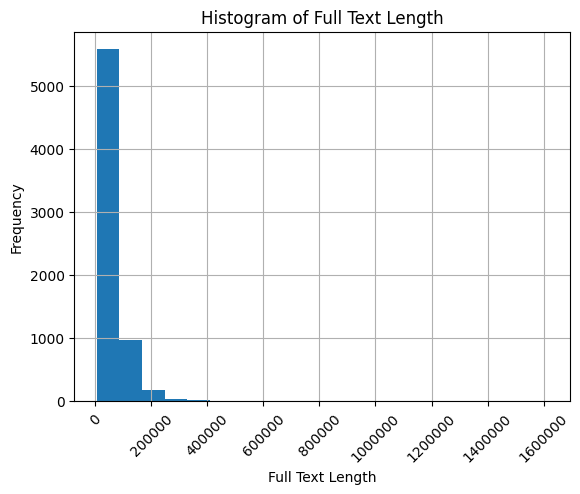

In [ ]:
text_lengths = [len(item['text']) for item in full_text_citing]
plt.hist(text_lengths, bins=20)
plt.xlabel('Full Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Full Text Length')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#TOOD: Full Text TF_IDF (training data)
tfidf_vectorizer1 = TfidfVectorizer(
    stop_words='english',
    max_features=60000,
    ngram_range=(1, 1),
    strip_accents='unicode',
    sublinear_tf= True
    )
tfidf_citing1, tfidf_nonciting1 = create_tfidf_matrix(full_text_citing, full_text_nonciting, tfidf_vectorizer1)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing1.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting1.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 60000
Shape of citing TF-IDF matrix: (6831, 60000)
Shape of citedTF-IDF matrix: (16837, 60000)


In [ ]:
cosine_similarities1 = linear_kernel(tfidf_citing1,tfidf_nonciting1)
cosine_similarities1

array([[0.15947739, 0.07032548, 0.09156124, ..., 0.13019904, 0.03670153,
        0.09880316],
       [0.07057263, 0.04357972, 0.1327829 , ..., 0.05593157, 0.09996435,
        0.08415764],
       [0.11183946, 0.0705481 , 0.1226307 , ..., 0.12903391, 0.05834044,
        0.12477986],
       ...,
       [0.11967054, 0.10242866, 0.14872317, ..., 0.13478352, 0.07522594,
        0.15056984],
       [0.06660411, 0.04331189, 0.07709275, ..., 0.05321843, 0.0695982 ,
        0.08377692],
       [0.04927392, 0.02806301, 0.05681495, ..., 0.04194719, 0.04560614,
        0.0788071 ]])

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank_full_text_train1 = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities1, k=k)

# Calculate the metrics
true_labels1, predicted_labels1, not_in_citation_mapping1 = \
    get_true_and_predicted(mapping_dict, top_k_rank_full_text_train1)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.3472
Recall at 20: 0.4252
Recall at 50: 0.5392
Recall at 100: 0.6206
Mean ranking: 49.9826
Mean average precision: 0.2024
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# for test
print("# --- On test corpus --- #")
full_text_citing_test = create_corpus(json_citing_test , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')


tfidf_citing_test1, tfidf_nonciting_test1 = create_tfidf_matrix(full_text_citing_test, full_text_nonciting, tfidf_vectorizer1)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing_test1.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting_test1.shape}")
cosine_similarities_test1 = linear_kernel(tfidf_citing_test1, tfidf_nonciting_test1)
cosine_similarities_test1

k = 100
top_k_rank_full_text_test1 = top_k_ranks(full_text_citing_test, full_text_nonciting, cosine_similarities_test1, k=k)


# --- On test corpus --- #
Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

In [ ]:

with open('prediction1_tfidf_full_text.json', 'w') as f:
    json.dump(top_k_rank_full_text_test1, f)

## 2.4. Combine 'title', 'abstract', 'claim1', 'claims':

- we will combine all the sections but we weight each part (testing to see if it works)
- we will test if perfoming some processing on the text gives better recall
- play with the parameters of tfidf

In [ ]:
# creation of train and test corpus for the fours sections
# 'title', 'abstract', 'claim1', 'claims'
citing_corpus_title = create_corpus(json_citing_train, 'title')
citing_corpus_abstract = create_corpus(json_citing_train, 'abstract')
citing_corpus_claim1 = create_corpus(json_citing_train, 'claim1')
citing_corpus_claims = create_corpus(json_citing_train, 'claims')

nonciting_corpus_title = create_corpus(json_nonciting, 'title')
nonciting_corpus_abstract = create_corpus(json_nonciting, 'abstract')
nonciting_corpus_claim1 = create_corpus(json_nonciting, 'claim1')
nonciting_corpus_claims = create_corpus(json_nonciting, 'claims')


Number of documents without title: 0
Number of documents without abstract: 0
Number of documents without claim 1: 0
Number of documents without claims: 0
Number of documents without title: 0
Number of documents without abstract: 7811
Removing 7811 documents without required text
Number of documents without claim 1: 3
Removing 3 documents without required text
Number of documents without claims: 3
Removing 3 documents without required text


In [ ]:
print(f"citing_corpus_title: {citing_corpus_title[:2]}")
print(f"citing_corpus_abstract: {citing_corpus_abstract[:2]}")
print(f"citing_corpus_claim1: {citing_corpus_claim1[:2]}")
print(f"citing_corpus_claims: {citing_corpus_claims[:2]}")

print(f"nonciting_corpus_title: {nonciting_corpus_title[:2]}")
print(f"nonciting_corpus_abstract: {nonciting_corpus_abstract[:2]}")
print(f"nonciting_corpus_claim1: {nonciting_corpus_claim1[:2]}")
print(f"nonciting_corpus_claims: {nonciting_corpus_claims[:2]}")


citing_corpus_title: [{'id': '3650293A1', 'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER'}, {'id': '3694265A1', 'text': 'TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION CHANNELS'}]
citing_corpus_abstract: [{'id': '3650293A1', 'text': 'The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (

In [ ]:
def create_weighted_corpus(corpus, sections_with_weights):
    """
    Combine multiple patent text sections into a single weighted corpus.

    Parameters:
        corpus (list): List of patent documents (JSON/dict format)
        sections_with_weights (list): List of tuples specifying (text_type, weight)
            Example: [("title", 1), ("abstract", 2), ("claims", 3)]

    Returns:
        list: Combined corpus with weighted text fields
    """
    weighted_corpus = []

    for doc in tqdm(corpus, desc="Creating weighted corpus"):
        combined_text = []
        app_id = doc["Application_Number"] + doc["Application_Category"]

        # Extract and weight each section
        for section, weight in sections_with_weights:
            try:
                # Replicate the text extraction logic from create_corpus()
                if section == "title":
                    text = doc["Content"]["title"]
                elif section == "abstract":
                    text = doc["Content"]["pa01"]
                elif section == "claim1":
                    text = doc["Content"]["c-en-0001"]
                elif section == "claims":
                    claims = [v for k,v in doc["Content"].items() if k.startswith("c-en-")]
                    text = " ".join(claims) if claims else None
                elif section == "description":
                    desc = [v for k,v in doc["Content"].items() if k.startswith("p")]
                    text = " ".join(desc) if desc else None
                elif section == "fulltext":
                    text = " ".join(doc["Content"].values())

                # Add weighted text (repeat text 'weight' times)
                if text:
                    combined_text.extend([text] * weight)

            except KeyError:
                continue  # Skip if section is missing

        if combined_text:
            weighted_corpus.append({
                "id": app_id,
                "text": " ".join(combined_text)
            })

    print(f"Created weighted corpus with {len(weighted_corpus)} documents")
    return weighted_corpus

In [ ]:
# Define section weights
section_weights = [
    ("title", 2),
    ("abstract", 2),
    ("claims", 3)
]

# Create combined corpora
citing_weighted = create_weighted_corpus(json_citing_train, section_weights)
nonciting_weighted = create_weighted_corpus(json_nonciting, section_weights)
citing_weighted_test = create_weighted_corpus(json_citing_test, section_weights)

Creating weighted corpus:   0%|          | 0/6831 [00:00<?, ?it/s]

Created weighted corpus with 6831 documents


Creating weighted corpus:   0%|          | 0/16837 [00:00<?, ?it/s]

Created weighted corpus with 16837 documents


Creating weighted corpus:   0%|          | 0/1000 [00:00<?, ?it/s]

Created weighted corpus with 1000 documents


In [ ]:
# define the vectorizer
tfidf_vectorizer_combined_text = TfidfVectorizer(
    stop_words='english',
    max_features=80000,
    ngram_range=(1, 1),
    strip_accents='unicode',
    sublinear_tf= True,
    )
tfidf_citing_combined_text, tfidf_nonciting_combined_text = create_tfidf_matrix(citing_weighted, nonciting_weighted, tfidf_vectorizer_combined_text)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing_combined_text.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting_combined_text.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 80000
Shape of citing TF-IDF matrix: (6831, 80000)
Shape of citedTF-IDF matrix: (16837, 80000)


In [ ]:
# compute the cosin sim
cosine_similarities_combined_text = linear_kernel(tfidf_citing_combined_text, tfidf_nonciting_combined_text)
cosine_similarities_combined_text

array([[0.07893686, 0.05638546, 0.05697324, ..., 0.11101624, 0.02324109,
        0.0654046 ],
       [0.02460792, 0.01093089, 0.03900988, ..., 0.0290951 , 0.06226895,
        0.02564064],
       [0.01884193, 0.02445447, 0.0508982 , ..., 0.06923877, 0.01996435,
        0.02570629],
       ...,
       [0.03053324, 0.03225257, 0.0501282 , ..., 0.03764765, 0.03515354,
        0.02739854],
       [0.04344242, 0.03599629, 0.02330674, ..., 0.0199249 , 0.0330305 ,
        0.04228714],
       [0.01254185, 0.02097445, 0.04135774, ..., 0.0081764 , 0.00992039,
        0.03780251]])

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank_combined_text_train = top_k_ranks(citing_weighted, nonciting_weighted, cosine_similarities_combined_text, k=k)
# Calculate the metrics
true_labels_combined_text_train, predicted_labels_combined_text_train, not_in_citation_mapping_combined_text = \
    get_true_and_predicted(mapping_dict, top_k_rank_combined_text_train)

mean_rank_combined_text_train = mean_ranking(true_labels_combined_text_train, predicted_labels_combined_text_train)
mean_average_precision_val_combined_text_train = mean_average_precision(true_labels_combined_text_train, predicted_labels_combined_text_train)
recall_at_10_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=10)
recall_at_20_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=20)
recall_at_50_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=50)
recall_at_100_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=100)

print("Recall at 10:", round(recall_at_10_combined_text_tfidf, 4))
print("Recall at 20:", round(recall_at_20_combined_text_tfidf, 4))
print("Recall at 50:", round(recall_at_50_combined_text_tfidf, 4))
print("Recall at 100:", round(recall_at_100_combined_text_tfidf, 4))


print("Mean ranking:", round(mean_rank_combined_text_train, 4))
print("Mean average precision:", round(mean_average_precision_val_combined_text_train, 4))
print("Number of patents measured:", len(predicted_labels_combined_text_train))
print("Number of patents not in the citation:", not_in_citation_mapping_combined_text)

Recall at 10: 0.6191
Recall at 20: 0.701
Recall at 50: 0.7956
Recall at 100: 0.8563
Mean ranking: 24.7913
Mean average precision: 0.406
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# for test
print("# --- On test corpus --- #")


tfidf_citing_combined_text_test, tfidf_nonciting_combined_text_test = create_tfidf_matrix(citing_weighted_test, nonciting_weighted, tfidf_vectorizer_combined_text)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing_combined_text_test.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting_combined_text_test.shape}")
cosine_similarities_combined_text_test = linear_kernel(tfidf_citing_combined_text_test, tfidf_nonciting_combined_text_test)
cosine_similarities_combined_text_test

k = 100
top_k_rankg_combined_text_test= top_k_ranks(citing_weighted_test, nonciting_weighted, cosine_similarities_combined_text_test, k=k)


# --- On test corpus --- #
Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Size of vocabulary: 80000
Shape of citing TF-IDF matrix: (1000, 80000)
Shape of citedTF-IDF matrix: (16837, 80000)


In [ ]:
# save the result to json file
with open('prediction1_weighted.json', 'w') as f:
    json.dump(top_k_rankg_combined_text_test, f)

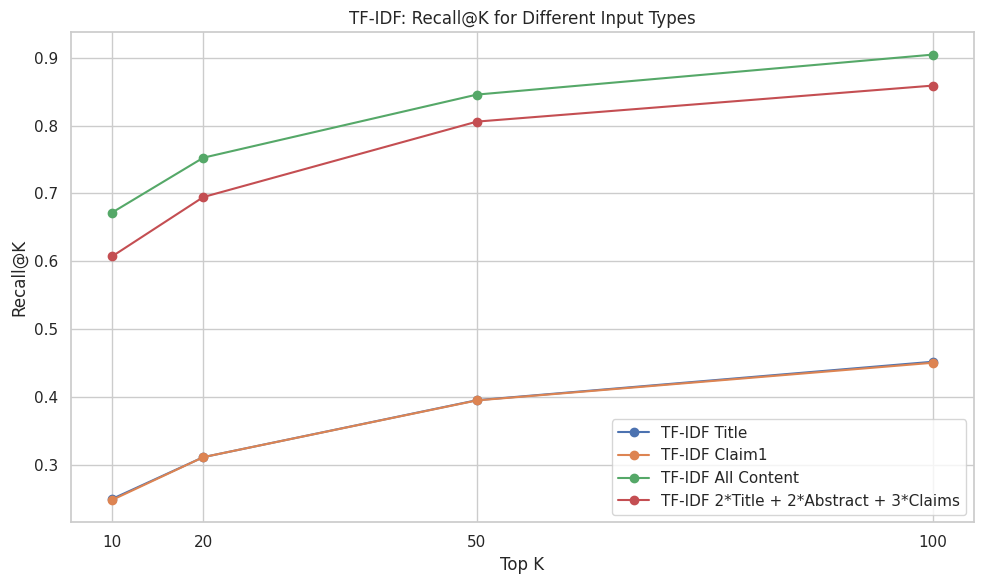

In [2]:
import matplotlib.pyplot as plt

k_values = [10, 20, 50, 100]

# Recall values from your results
recall_tfidf_title = [0.24975, 0.31133, 0.39533, 0.452]
recall_tfidf_claim1 = [0.24825, 0.31133, 0.395, 0.4505]
recall_tfidf_all_content = [0.67183, 0.75267, 0.84575, 0.90467]
recall_tfidf_weighted = [0.60725, 0.69467, 0.80592, 0.859]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(k_values, recall_tfidf_title, label='TF-IDF Title', marker='o')
plt.plot(k_values, recall_tfidf_claim1, label='TF-IDF Claim1', marker='o')
plt.plot(k_values, recall_tfidf_all_content, label='TF-IDF All Content', marker='o')
plt.plot(k_values, recall_tfidf_weighted, label='TF-IDF 2*Title + 2*Abstract + 3*Claims', marker='o')

plt.xlabel('Top K')
plt.ylabel('Recall@K')
plt.title('TF-IDF: Recall@K for Different Input Types')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3.0 BM-25

## 3.1 Initialize BM25 Class

In [ ]:
class BM25Score:
    """BM25 scoring algorithm implementation for document ranking."""

    def __init__(self, vectorized_docs, k1=1.5, b=0.75):
        """
        Initialize the BM25Score object.

        Parameters:
        - vectorized_docs (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized documents.
        - k1 (float, optional): Tuning parameter that controls term frequency normalization. Default is 1.5.
        - b (float, optional): Tuning parameter that controls the impact of document length normalization. Default is 0.75.
        """
        self.k1 = k1
        self.b = b
        self.vectorized_docs = vectorized_docs

    def fit(self, vectorized_queries=None, query_ids=None, args=None):
        """
        Fit the BM25 model to the provided vectorized documents.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix, optional): Sparse matrix of word counts representing vectorized queries. Default is None.
        - query_ids (list, optional): List of query IDs. Default is None.
        - args (dict, optional): Additional arguments for grid search integration. Default is None.

        Returns:
        - self (BM25Score): Returns the instance of the BM25Score object after fitting.
        """
        self.n_d = self.vectorized_docs.sum(axis=1).reshape(-1, 1).A
        self.avgdl = np.mean(self.n_d)
        self.n_docs = self.vectorized_docs.shape[0]

        self.nq = np.sum(self.vectorized_docs > 0, axis=0).reshape(1, -1)
        self.idf = np.log(((self.n_docs - self.nq + 0.5) / (self.nq + 0.5)) + 1).A
        return self

    def predict(self, vectorized_queries):
        """
        Predict relevance scores for the given vectorized queries.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized queries.

        Returns:
        - scores (numpy.ndarray): Array of relevance scores for the queries.
        """
        idx_tokens = np.argwhere(vectorized_queries.sum(axis=0) > 0).reshape(-1)
        vectorized_queries = vectorized_queries[:, idx_tokens]
        vectorized_docs = self.vectorized_docs[:, idx_tokens].toarray()
        idf = self.idf[:, idx_tokens]

        scores = idf * (
            (vectorized_docs * (self.k1 + 1)) / \
            (
                vectorized_docs + \
                self.k1 * (1 - self.b + self.b * (self.n_d / self.avgdl))
            )
        )

        return (vectorized_queries > 0).astype(np.int8) @ scores.T

def create_bm25_matrix(citing_dataset, nonciting_dataset, vectorizer=CountVectorizer()):
    """
    Creates BM25 similarity scores for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (CountVectorizer, optional): CountVectorizer object for vectorizing text data.
                                            Defaults to CountVectorizer().

    Returns:
    array: Similarity scores matrix between citing and non-citing patents.
    """
    all_text_citing = [patent['text'] for patent in citing_dataset]
    all_text_nonciting = [patent['text'] for patent in nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    vectorizer.fit(all_text_citing + all_text_nonciting)
    count_matrix_citing = vectorizer.transform(all_text_citing)
    count_matrix_nonciting = vectorizer.transform(all_text_nonciting)

    # Using BM25 scoring
    print("Computing BM25 scores...")
    bm25 = BM25Score(count_matrix_nonciting)
    bm25.fit()
    bm25_scores = bm25.predict(count_matrix_citing)

    return bm25_scores

## 3.2 'Title' BM25

In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(title_citing_train, title_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (6831, 16837)


In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_bm25, 4))
print("Recall at 20:", round(recall_at_20_titles_bm25, 4))
print("Recall at 50:", round(recall_at_50_titles_bm25, 4))
print("Recall at 100:", round(recall_at_100_titles_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2687
Recall at 20: 0.3297
Recall at 50: 0.4115
Recall at 100: 0.4719
Mean ranking: 61.6857
Mean average precision: 0.1655
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# on test
print("# --- On test corpus --- #")
bm25_scores_test = create_bm25_matrix(title_citing_test, title_nonciting)
top_k_rank_title_test = top_k_ranks(title_citing_test, title_nonciting, bm25_scores_test, k=k)

# --- On test corpus --- #
Vectorizing descriptions...
Computing BM25 scores...


## 3.3 'Claims1' BM25

In [ ]:
print(f"Number of citing: {len(claim1_citing)}")
print(f"Number of nonciting: {len(claim1_nonciting)}")
print(f"Sum: {len(claim1_citing) + len(claim1_nonciting)}")

Number of citing: 6831
Number of nonciting: 16834
Sum: 23665


In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(claim1_citing, claim1_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...


In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_bm25, 4))
print("Recall at 20:", round(recall_at_20_claim1_bm25, 4))
print("Recall at 50:", round(recall_at_50_claim1_bm25, 4))
print("Recall at 100:", round(recall_at_100_claim1_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

In [ ]:
len(true_labels)

6831

In [ ]:
len(predicted_labels[0])

100

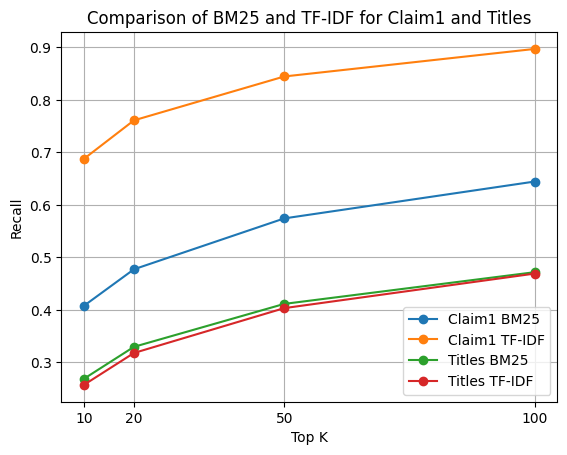

In [ ]:
k_values = [10, 20, 50, 100]

plt.plot(k_values, [recall_at_10_claim1_bm25, recall_at_20_claim1_bm25, recall_at_50_claim1_bm25, recall_at_100_claim1_bm25], label='Claim1 BM25', marker='o')
plt.plot(k_values, [recall_at_10_claim1_tfidf, recall_at_20_claim1_tfidf, recall_at_50_claim1_tfidf, recall_at_100_claim1_tfidf], label='Claim1 TF-IDF', marker='o')
plt.plot(k_values, [recall_at_10_titles_bm25, recall_at_20_titles_bm25, recall_at_50_titles_bm25, recall_at_100_titles_bm25], label='Titles BM25', marker='o')
plt.plot(k_values, [recall_at_10_titles_tfidf, recall_at_20_titles_tfidf, recall_at_50_titles_tfidf, recall_at_100_titles_tfidf], label='Titles TF-IDF', marker='o')

plt.xlabel('Top K')
plt.ylabel('Recall')
plt.title('Comparison of BM25 and TF-IDF for Claim1 and Titles')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

## 3.4 'All Content' BM25

In [ ]:
# creattion of the corpus

full_text_citing = create_corpus(json_citing_train , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')

full_text_citing_test = create_corpus(json_citing_test , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')

In [ ]:
tfidf_vectorizer1 = TfidfVectorizer(
    stop_words='english',
    max_features=60000,
    ngram_range=(1, 1),
    strip_accents='unicode',
    sublinear_tf= True
    )

In [ ]:
# Create BM25 similarity scores on full_text
bm25_scores_full_text = create_bm25_matrix(full_text_citing, full_text_nonciting, tfidf_vectorizer1)

print(f"Shape of BM25 scores matrix: {bm25_scores_full_text.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (6831, 16837)


In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(full_text_citing, full_text_nonciting, bm25_scores_full_text, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_bm25, 4))
print("Recall at 20:", round(recall_at_20_titles_bm25, 4))
print("Recall at 50:", round(recall_at_50_titles_bm25, 4))
print("Recall at 100:", round(recall_at_100_titles_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.5674
Recall at 20: 0.6525
Recall at 50: 0.7466
Recall at 100: 0.8073
Mean ranking: 29.6062
Mean average precision: 0.3664
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# on test full_text
print("# --- On test corpus --- #")

bm25_scores_full_text_test = create_bm25_matrix(full_text_citing_test, full_text_nonciting, tfidf_vectorizer1)
top_k_rank_full_text_test = top_k_ranks(full_text_citing_test, full_text_nonciting, bm25_scores_full_text_test, k=k)

# --- On test corpus --- #
Vectorizing descriptions...
Computing BM25 scores...


In [ ]:
with open('prediction1_bm25_allContent.json', 'w') as f:
    json.dump(top_k_rank, f)

### Combined text

In [ ]:
def create_weighted_corpus(corpus, sections_with_weights):
    """
    Combine multiple patent text sections into a single weighted corpus.

    Parameters:
        corpus (list): List of patent documents (JSON/dict format)
        sections_with
        with_weights (list): List of tuples specifying (text_type, weight)
            Example: [("title", 1), ("abstract", 2), ("claims", 3)]

    Returns:
        list: Combined corpus with weighted text fields
    """
    weighted_corpus = []
    for doc in tqdm(corpus, desc="Creating weighted corpus"):
        combined_text = []
        app_id = doc["Application_Number"] + doc["Application_Category"]
        for section, weight in sections_with_weights:
            try:


In [ ]:
section_weights = [
    ("claims", 3),
    ("abstract", 2),
    ("title", 1)
]

# Test different (k1, b) combinations
param_grid = {
    'k1': [1.2, 1.5, 1.8],
    'b': [0.6, 0.75, 0.9]
}

# 1. Create weighted corpus
section_weights = [("claims", 3), ("abstract", 2)]
citing_weighted = create_weighted_corpus(json_citing_train, section_weights)
nonciting_weighted = create_weighted_corpus(json_nonciting, section_weights)

# 2. Preprocess with stemming and n-grams
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=custom_stopwords,
    preprocessor=stemmer.stem
)

# 3. Tune BM25 parameters (k1=1.5, b=0.75)
bm25_scores = create_bm25_matrix(citing_weighted, nonciting_weighted, vectorizer)

# 4. Generate top-100 rankings
top_100 = top_k_ranks(citing_weighted, nonciting_weighted, bm25_scores, k=100)


NameError: name 'create_weighted_corpus' is not defined

# 4.0 Get Test Predictions for CodaBench

In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(title_citing_test, title_nonciting)
top_k_rank = top_k_ranks(title_citing_test, title_nonciting, bm25_scores, k=k)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (1000, 16837)


In [ ]:
with open('prediction1.json', 'w') as f:
    json.dump(top_k_rank, f)

# Dependencies:

In [ ]:
!pip install transformers torch

import os
import json
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# 0. Loading data files

In [ ]:
# PATHS
train_queries_file = "train_queries.json"
test_queries_file = "test_queries.json"
train_gold_mapping_file = "train_gold_mapping.json"
shuffled_pre_ranking_file = "shuffled_pre_ranking.json"
queries_content_file = "queries_content_with_features.json"
documents_content_file = "documents_content_with_features.json"

test_predictions_file = "prediction2.json"

if not all(os.path.exists(f) for f in [test_queries_file, shuffled_pre_ranking_file, queries_content_file, documents_content_file]):
    print("Error: One or more necessary data files for the test set are missing.")
    exit()
else:
    print("Necessary data files for the test set found.")

Necessary data files for the test set found.


In [ ]:
# LOAD

def load_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

test_queries = load_json_file(test_queries_file)
print(f"Loaded {len(test_queries)} test queries.")

pre_ranking_test = load_json_file(shuffled_pre_ranking_file)
# filter pre-ranking to include only test queries (important!)
pre_ranking_test_filtered = {fan: docs for fan, docs in pre_ranking_test.items() if fan in test_queries}
print(f"Filtered pre-ranking to {len(pre_ranking_test_filtered)} test queries.")


queries_content = load_json_file(queries_content_file)
documents_content = load_json_file(documents_content_file)


if not os.path.exists("cross_encoder_reranking_train.py"):
    print("Error: The 'cross_encoder_reranking_train.py' script is missing. Please upload it.")
    exit()
else:
    print("Reranking script found.")

Loaded 10 test queries.
Filtered pre-ranking to 10 test queries.
Reranking script found.


# 1. Re-ranking the results with cross-encoder:

We will use the model ` "intfloat/e5-large-v2" `with different combinations of the documents parts like: `ta`, `tac1`....etc

In [ ]:
base_dir ="/content" # adapt this base dir according to your folders  (/content when using google colab and the files are directly in /content)


## 1.1.1. E5 LARGE TA

In [ ]:
# E5 LARGE ta

best_model_name = "intfloat/e5-large-v2"
best_text_type = "TA"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model intfloat/e5-large-v2...
tokenizer_config.json: 100% 314/314 [00:00<00:00, 2.66MB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 5.93MB/s]
tokenizer.json: 100% 711k/711k [00:00<00:00, 15.3MB/s]
special_tokens_map.json: 100% 125/125 [00:00<00:00, 1.25MB/s]
config.json: 100% 616/616 [00:00<00:00, 4.77MB/s]
model.safetensors: 100% 1.34G/1.34G [00:05<00:00, 245MB/s]
Starting re-ranking process for training queries...
Processing queries:   0% 0/10 [00:00<?, ?it/s]
Re-ranking 30 documents for training query 103964109
Original pre-ranking (first 3): ['94596291', '65451984', '81098918']

Scoring documents:   0% 0/8 [00:00<?, ?it/s]
Scori

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_e5Large_TA.json`

## 1.1.2. E5 LARGE tac1

In [ ]:
# E5 LARGE tac1

best_model_name = "intfloat/e5-large-v2"
best_text_type = "tac1"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")



Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model intfloat/e5-large-v2...
Starting re-ranking process for training queries...
Processing queries:   0% 0/10 [00:00<?, ?it/s]
Re-ranking 30 documents for training query 103964109
Original pre-ranking (first 3): ['94596291', '65451984', '81098918']

Scoring documents:   0% 0/8 [00:00<?, ?it/s]
Scoring documents:  12% 1/8 [00:02<00:18,  2.59s/it]
Scoring documents:  25% 2/8 [00:05<00:15,  2.58s/it]
Scoring documents:  38% 3/8 [00:07<00:12,  2.57s/it]
Scoring documents:  50% 4/8 [00:09<00:09,  2.27s/it]
Scoring documents:  62% 5/8 [00:11<00:06,  2.19s/it]
Scoring documents:  75% 6/8 [00:13<00:04,  2.04s/it]
Scoring documents:  88%

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_e5Large_TAC1.json`

## 1.1.3. E5 LARGE CLAIMS

In [ ]:
# E5 LARGE CLAIMS

best_model_name = "intfloat/e5-large-v2"
best_text_type = "claims"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model intfloat/e5-large-v2...
Starting re-ranking process for training queries...
Processing queries:   0% 0/10 [00:00<?, ?it/s]
Re-ranking 30 documents for training query 103964109
Original pre-ranking (first 3): ['94596291', '65451984', '81098918']

Scoring documents:   0% 0/8 [00:00<?, ?it/s]
Scoring documents:  12% 1/8 [00:02<00:18,  2.68s/it]
Scoring documents:  25% 2/8 [00:05<00:15,  2.63s/it]
Scoring documents:  38% 3/8 [00:07<00:12,  2.52s/it]
Scoring documents:  50% 4/8 [00:10<00:09,  2.46s/it]
Scoring documents:  62% 5/8 [00:12<00:07,  2.45s/it]
Scoring documents:  75% 6/8 [00:15<00:05,  2.51s/it]
Scoring documents:  88%

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_e5Large_CLAIMS.json`

##1.1.4. E5 LARGE DESCRIPTION

In [ ]:
# E5 LARGE DESCRIPTION

best_model_name = "intfloat/e5-large-v2"
best_text_type = "description"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")

## 1.2.1. MPNET TA

In [ ]:
# MPNET TA

best_model_name = "sentence-transformers/all-mpnet-base-v2"

best_text_type = "TA"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model sentence-transformers/all-mpnet-base-v2...
tokenizer_config.json: 100% 363/363 [00:00<00:00, 3.27MB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 5.33MB/s]
tokenizer.json: 100% 466k/466k [00:00<00:00, 892kB/s]
special_tokens_map.json: 100% 239/239 [00:00<00:00, 1.43MB/s]
config.json: 100% 571/571 [00:00<00:00, 4.45MB/s]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
model.safetensors: 100% 438M/438M [00:01<00:00, 255MB/s]
Starting re-ranking proc

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_MPNET_TA.json`

## 1.2.2. MPNET CLAIMS

In [ ]:
# MPNET CLAIMS

best_model_name = "sentence-transformers/all-mpnet-base-v2"

best_text_type = "claims"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model sentence-transformers/all-mpnet-base-v2...
Starting re-ranking process for training queries...
Processing queries:   0% 0/10 [00:00<?, ?it/s]
Re-ranking 30 documents for training query 103964109
Original pre-ranking (first 3): ['94596291', '65451984', '81098918']

Scoring documents:   0% 0/8 [00:00<?, ?it/s]
Scoring documents:  12% 1/8 [00:00<00:06,  1.03it/s]
Scoring documents:  25% 2/8 [00:01<00:05,  1.08it/s]
Scoring documents:  38% 3/8 [00:02<00:04,  1.11it/s]
Scoring documents:  50% 4/8 [00:03<00:03,  1.13it/s]
Scoring documents:  62% 5/8 [00:04<00:02,  1.13it/s]
Scoring documents:  75% 6/8 [00:05<00:01,  1.16it/s]
Scor

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_MPNET_CLAIMS.json`

## 1.2.3. MPNET full (very bad)

In [ ]:
# MPNET full

best_model_name = "sentence-transformers/all-mpnet-base-v2"

best_text_type = "full"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model sentence-transformers/all-mpnet-base-v2...
2025-04-08 20:40:35.933535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744144835.980489    4422 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744144835.992981    4422 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 20:40:36.034571

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_MPNET_full.json`

Reading truth and prediction
Checking Accuracy
Scores:
{'recall_at_3': 0.08055555555555556, 'recall_at_5': 0.10555555555555556, 'recall_at_10': 0.2595238095238095, 'recall_at_20': 0.7492063492063492, 'mean_rank': 14.783333333333331, 'mean_inv_rank': 0.10828456299601233, 'mean_average_precision': 0.19408953742409024}
Scoring completed

## 1.2.4. MPNET description (highest score)

In [ ]:
# MPNET description

best_model_name = "sentence-transformers/all-mpnet-base-v2"

best_text_type = "description"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model sentence-transformers/all-mpnet-base-v2...
2025-04-09 00:40:54.119862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744159254.153456   61864 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744159254.163426   61864 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 00:40:54.212405

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_MPNET_description.json`

## 1.2.5. MPNET description + features


In [ ]:
best_model_name = "sentence-transformers/all-mpnet-base-v2"

best_text_type = "description_features"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length} \
    --base_dir "{base_dir}"

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model sentence-transformers/all-mpnet-base-v2...
2025-04-09 02:12:07.679515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744164727.715707   83684 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744164727.725714   83684 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 02:12:07.773526

**REMARK**: We rename the `Test set predictions saved to: prediction2.json`to `prediction2_MPNET_DescFeat.json`

## 1.3.1. BGE TA

In [ ]:
# BGE TA

best_model_name = "BAAI/bge-large-en"

best_text_type = "TA"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length}

print(f"\nTest set predictions saved to: {test_predictions_file}")


Running reranking on the test set...
Loading training queries from test_queries.json...
Loaded 10 training queries
Loading pre-ranking data from shuffled_pre_ranking.json...
Filtered pre-ranking to 10 training queries
Loading query content from queries_content_with_features.json...
Loading document content from documents_content_with_features.json...
Loading model BAAI/bge-large-en...
2025-04-07 16:57:57.396788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744045077.475814  135585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744045077.496851  135585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 16:57:57.597356: I tensorflow/core/pl

## 1.3.2. BGE tac1

In [ ]:
# BGE tac1

best_model_name = "BAAI/bge-large-en"

best_text_type = "tac1"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length}

print(f"\nTest set predictions saved to: {test_predictions_file}")

## 1.3.3. BGE description

In [ ]:
# BGE description

best_model_name = "BAAI/bge-large-en"

best_text_type = "description"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length}

print(f"\nTest set predictions saved to: {test_predictions_file}")

1.3.4. BGE claims

In [ ]:
# BGE claims

best_model_name = "BAAI/bge-large-en"

best_text_type = "claims"
max_length = 512

print("\nRunning reranking on the test set...")
!python cross_encoder_reranking_train.py \
    --model_name "{best_model_name}" \
    --text_type "{best_text_type}" \
    --pre_ranking "{shuffled_pre_ranking_file}" \
    --queries_list "{test_queries_file}" \
    --queries_content "{queries_content_file}" \
    --documents_content "{documents_content_file}" \
    --output "{test_predictions_file}" \
    --max_length {max_length}

print(f"\nTest set predictions saved to: {test_predictions_file}")

## 1.4. GEMINI try (failure due API quota limitations)

For this model there are some limitations

In [ ]:
# GEMINI TRY

import time
import os
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from google import genai

# gemini API key
GEMINI_API_KEY = "ton api"

client = genai.Client(api_key=GEMINI_API_KEY)
embedding_model_name = "gemini-embedding-exp-03-07"

train_queries_file = "train_queries.json"
test_queries_file = "test_queries.json"
train_gold_mapping_file = "train_gold_mapping.json"
shuffled_pre_ranking_file = "shuffled_pre_ranking.json"
queries_content_file = "queries_content_with_features.json"
documents_content_file = "documents_content_with_features.json"

test_predictions_file = "predictions_gemini_exp.json"

if not all(os.path.exists(f) for f in [test_queries_file, shuffled_pre_ranking_file, queries_content_file, documents_content_file]):
    print("Error: One or more necessary data files for the test set are missing.")
    exit()
else:
    print("Necessary data files for the test set found.")

def load_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def save_json_file(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=2)

def load_content_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    # a dictionary mapping FAN to Content
    content_dict = {item['FAN']: item['Content'] for item in data}
    return content_dict

def extract_text(content_dict, text_type="full"):
    if text_type == "TA" or text_type == "title_abstract":
        title = content_dict.get("title", "")
        abstract = content_dict.get("pa01", "")
        return f"{title} {abstract}".strip()
    elif text_type == "claims":
        claims = " ".join([v for k, v in content_dict.items() if k.startswith('c-')])
        return claims.strip()
    elif text_type == "description":
        description = " ".join([v for k, v in content_dict.items() if k.startswith('p')])
        return description.strip()
    elif text_type == "full":
        all_text = []
        if "title" in content_dict:
            all_text.append(content_dict["title"])
        if "pa01" in content_dict:
            all_text.append(content_dict["pa01"])
        for key, value in content_dict.items():
            if key not in ["title", "pa01"]:
                all_text.append(value)
        return " ".join(all_text).strip()
    elif text_type == "tac1":
        title = content_dict.get("title", "")
        abstract = content_dict.get("pa01", "")
        first_claim = next((v for k, v in content_dict.items() if k.startswith('c-')), "")
        return f"{title} {abstract} {first_claim}".strip()
    return ""

def get_embedding_gemini(text_list, batch_size=1):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        try:
            result = client.models.embed_content(
                model=embedding_model_name,
                contents=batch,
            )
            if result.embeddings:
                for embedding in result.embeddings:
                    embeddings.append(embedding.values)
            else:
                print(f"Warning: No embeddings returned for the batch starting at index {i}")
                return None
            time.sleep(1)  # small delay to avoid rate limits
        except Exception as e:
            print(f"Error getting Gemini embeddings for batch starting at index {i}: {e}")
            return None
    return embeddings

# test queries and pre-ranking
test_queries = load_json_file(test_queries_file)
print(f"Loaded {len(test_queries)} test queries.")
pre_ranking_test = load_json_file(shuffled_pre_ranking_file)
pre_ranking_test_filtered = {fan: docs for fan, docs in pre_ranking_test.items() if fan in test_queries}
print(f"Filtered pre-ranking to {len(pre_ranking_test_filtered)} test queries.")

# content data
queries_content = load_content_data(queries_content_file)
documents_content = load_content_data(documents_content_file)

# gemini embeddings
re_ranked_predictions = {}
best_text_type = "claims"

print("\nStarting reranking process for test queries using Gemini Embedding Model...")
for query_fan, pre_ranked_docs in tqdm(pre_ranking_test_filtered.items(), desc="Processing queries"):
    if query_fan not in queries_content:
        print(f"Warning: Query FAN {query_fan} not found in content.")
        re_ranked_predictions[query_fan] = pre_ranked_docs
        continue

    query_text = extract_text(queries_content[query_fan], best_text_type)
    doc_texts = []
    doc_fans = []
    for doc_fan in pre_ranked_docs:
        if doc_fan in documents_content:
            doc_texts.append(extract_text(documents_content[doc_fan], best_text_type))
            doc_fans.append(doc_fan)
        else:
            print(f"Warning: Document FAN {doc_fan} not found in content.")

    if not doc_texts:
        re_ranked_predictions[query_fan] = []
        continue

    all_texts = [query_text] + doc_texts
    embeddings = get_embedding_gemini(all_texts)

    if embeddings and len(embeddings) == len(all_texts):
        query_embedding = embeddings[0]
        doc_embeddings = embeddings[1:]
        similarity_scores = cosine_similarity([query_embedding], doc_embeddings)[0]
        ranked_indices = np.argsort(similarity_scores)[::-1]
        re_ranked_predictions[query_fan] = [doc_fans[i] for i in ranked_indices]
    else:
        print(f"Warning: Could not get embeddings for query {query_fan}. Keeping original ranking.")
        re_ranked_predictions[query_fan] = pre_ranked_docs

save_json_file(re_ranked_predictions, test_predictions_file)
print(f"\nTest set predictions saved to: {test_predictions_file}")


Necessary data files for the test set found.
Loaded 10 test queries.
Filtered pre-ranking to 10 test queries.

Starting reranking process for test queries using Gemini Embedding Model...


Processing queries:  10%|█         | 1/10 [00:12<01:53, 12.65s/it]

Error getting Gemini embeddings for batch starting at index 6: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing queries:  40%|████      | 4/10 [00:13<00:12,  2.04s/it]

Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing queries:  60%|██████    | 6/10 [00:13<00:04,  1.11s/it]

Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing queries: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error getting Gemini embeddings for batch starting at index 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}

Test set predictions saved to: predictions_gemini_exp.json

Remember to download '{test_predictions_file}' and submit it to Codabench.


VANILLA TFIDF (0.19 score)

In [ ]:
!pip install fuzzywuzzy
import os
import json
import math
from collections import Counter
from fuzzywuzzy import fuzz  # pip install fuzzywuzzy
from nltk.corpus import wordnet  # pip install nltk (and download wordnet data: import nltk; nltk.download('wordnet'))

# PATHS
train_queries_file = "train_queries.json"
test_queries_file = "test_queries.json"
train_gold_mapping_file = "train_gold_mapping.json"
shuffled_pre_ranking_file = "shuffled_pre_ranking.json"
queries_content_file = "queries_content_with_features.json"
documents_content_file = "documents_content_with_features.json"
test_predictions_file = "creative_predictions.json"

def load_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

if not all(os.path.exists(f) for f in [test_queries_file, shuffled_pre_ranking_file, queries_content_file, documents_content_file, train_gold_mapping_file, queries_content_file, documents_content_file, train_queries_file]):
    print("Error: One or more necessary data files are missing.")
    exit()
else:
    print("Necessary data files found.")

test_queries = load_json_file(test_queries_file)
pre_ranking_test = load_json_file(shuffled_pre_ranking_file)
pre_ranking_test_filtered = {fan: docs for fan, docs in pre_ranking_test.items() if fan in test_queries}
train_gold_mapping = load_json_file(train_gold_mapping_file)
train_queries = load_json_file(train_queries_file)

queries_content_list = load_json_file(queries_content_file)
queries_content = {}
for item in queries_content_list:
    patent_id = item.get("patent_id")
    if patent_id:
        queries_content[patent_id] = item
print(f"Loaded and processed {len(queries_content)} query content items.")

documents_content_list = load_json_file(documents_content_file)
documents_content = {}
for item in documents_content_list:
    patent_id = item.get("patent_id")
    if patent_id:
        documents_content[patent_id] = item
print(f"Loaded and processed {len(documents_content)} document content items.")

queries_content_train = {k: v for k, v in queries_content.items() if k in train_queries}
documents_content_train = documents_content

def prepare_feature_weights_tfidf(train_gold_mapping, queries_content, documents_content):
    doc_feature_counts = {}
    all_docs = {**queries_content, **documents_content}
    total_num_docs = len(all_docs)

    for doc_id, content in all_docs.items():
        features = content.get('features', [])
        doc_feature_counts[doc_id] = Counter(features)

    feature_doc_frequency = Counter()
    for doc_id, counts in doc_feature_counts.items():
        for feature in counts:
            feature_doc_frequency[feature] += 1

    feature_weights_tfidf = {}
    for doc_id, counts in doc_feature_counts.items():
        for feature, count in counts.items():
            tf = count / (sum(counts.values()) + 1e-6)
            idf = math.log(total_num_docs / (feature_doc_frequency[feature] + 1) + 1e-6)
            feature_weights_tfidf[feature] = feature_weights_tfidf.get(feature, 0) + tf * idf

    return dict(feature_weights_tfidf)

def calculate_feature_similarity_improved(query_features, doc_features, feature_weights_tfidf=None):
    score = 0

    # tfidf weighted overlap
    if feature_weights_tfidf:
        common_features = set(query_features) & set(doc_features)
        for feature in common_features:
            score += feature_weights_tfidf.get(feature, 0)

    # fuzzy matching
    fuzzy_score = 0
    for q_feature in query_features:
        for d_feature in doc_features:
            ratio = fuzz.ratio(q_feature, d_feature)
            if ratio > 85:  # Increased threshold
                fuzzy_score += ratio / 100.0 * 0.2  # Reduced weight

    score += fuzzy_score

    # n-gram overlap (bi-grams)
    def get_ngrams(text, n):
        n_grams = set()
        words = text.split()
        for i in range(len(words) - n + 1):
            n_grams.add(" ".join(words[i:i+n]))
        return n_grams

    ngram_overlap_score = 0
    for q_feature in query_features:
        for d_feature in doc_features:
            q_2grams = get_ngrams(q_feature, 2)
            d_2grams = get_ngrams(d_feature, 2)
            overlap = len(q_2grams & d_2grams)
            union = len(q_2grams | d_2grams)
            if union > 0:
                ngram_overlap_score += overlap / union * 0.1

    score += ngram_overlap_score

    return score

def creative_reranking(pre_ranking, queries_content, documents_content, feature_weights_tfidf=None):
    ranked_results = {}
    for query_id, initial_ranking in pre_ranking.items():
        if query_id in queries_content:
            query_features = queries_content[query_id].get('features', [])
            scored_documents = []
            for doc_id in initial_ranking:
                if doc_id in documents_content:
                    doc_features = documents_content[doc_id].get('features', [])
                    similarity_score = calculate_feature_similarity_improved(
                        query_features,
                        doc_features,
                        feature_weights_tfidf=feature_weights_tfidf
                    )
                    scored_documents.append((doc_id, similarity_score))
            scored_documents.sort(key=lambda item: item[1], reverse=True)
            ranked_results[query_id] = [doc_id for doc_id, score in scored_documents]
        else:
            ranked_results[query_id] = initial_ranking
    return ranked_results

feature_weights_tfidf = prepare_feature_weights_tfidf(train_gold_mapping, queries_content_train, documents_content_train)

reranked_predictions = creative_reranking(
    pre_ranking_test_filtered,
    queries_content,
    documents_content,
    feature_weights_tfidf=feature_weights_tfidf
)

with open(test_predictions_file, 'w') as f:
    json.dump(reranked_predictions, f, indent=4)

print(f"\nTest set predictions saved to: {test_predictions_file}")

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Necessary data files found.
Loaded and processed 0 query content items.
Loaded and processed 0 document content items.

Creative test set predictions saved to: creative_predictions.json


# 2. Spars ranking with tf-idf vectorizer (from task 1)

## 2.1. Utils

In [ ]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):

    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting


# a new function to create the copus
import re

def create_corpus(corpus, text_type):

    valid_app_ids = []
    texts = []
    cnt = 0
    ids_to_remove = []

    for docBloc in corpus:
        doc_id = docBloc.get('FAN')
        if doc_id is None:
            continue

        doc = docBloc['Content']
        valid = False
        text = ''

        if text_type == 'title':
            if 'title' in doc:
                text = doc['title']
                valid = True
        elif text_type == 'abstract':
            if 'pa01' in doc:
                text = doc['pa01']
                valid = True
        elif text_type == 'claim1':
            if 'c-en-0001' in doc:
                text = doc['c-en-0001']
                valid = True
        elif text_type == 'claims':
            claims = [doc[k] for k in doc if k.startswith('c-en-')]
            if claims:
                text = ' '.join(claims)
                valid = True
        elif text_type == 'description':
            desc_parts = [doc[k] for k in doc if re.match(r'^p\d{4}$', k)]
            if desc_parts:
                text = ' '.join(desc_parts)
                valid = True
        elif text_type == 'fulltext':
            text_parts = [str(doc[k]) for k in doc if k != 'id']
            if text_parts:
                text = ' '.join(text_parts)
                valid = True
        elif text_type == 'features':
            try:
                features_dict = doc['features']
                features = list(features_dict.values())
                if features:
                    text = ' '.join(features)
                    valid = True
                else:
                    raise KeyError
            except KeyError:
                print("an error !")
        elif text_type == 'TAC1':
            required = ['title', 'pa01', 'c-en-0001']
            if all(k in doc for k in required):
                text = ' '.join([doc['title'], doc['pa01'], doc['c-en-0001']])
                valid = True
        elif text_type == 'TA':
            required = ['title', 'pa01']
            if all(k in doc for k in required):
                text = ' '.join([doc['title'], doc['pa01']])
                valid = True
        elif text_type == 'TAC1F':
            required = ['title', 'pa01', 'c-en-0001', 'features']
            if all(k in doc for k in required):
                text_parts = [doc['title'], doc['pa01'], doc['c-en-0001']]
                try:
                    features_dict = doc['features']
                    features = list(features_dict.values())
                    if features:
                        text_parts.append(' '.join(features))
                        text = ' '.join(text_parts)
                        valid = True
                    else:
                        raise KeyError
                except KeyError:
                    print("an error !")
        elif text_type == 'description_F':
            desc_parts = [doc[k] for k in doc if re.match(r'^p\d{4}$', k)]
            try:
                features_dict = doc['features']
                features = list(features_dict.values())
                if features:
                    text = ' '.join(desc_parts) + ' ' + ' '.join(features)
                    valid = True
                else:
                    raise KeyError
            except KeyError:
                print("an error !")
        else:
            raise ValueError("Invalid text type")

        if valid:
            valid_app_ids.append(doc_id)
            texts.append(text)
        else:
            cnt += 1
            ids_to_remove.append(doc_id)

    print(f"Number of documents without {text_type}: {cnt}")
    if ids_to_remove:
        print(f"Removing {len(ids_to_remove)} documents without required text")

    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(valid_app_ids, texts)]

    return corpus_data



def top_k_ranks(citing, cited, cosine_similarities, k=10):
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['FAN']] = [cited[j]['FAN'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks


## 2.2 Upload the data

In [ ]:
import json

with open("train_queries.json") as f:
    train_queries = json.load(f)

with open("train_gold_mapping.json") as f:
    train_gold_mapping = json.load(f)

with open("shuffled_pre_ranking.json") as f:
    pre_ranking = json.load(f)

with open("queries_content_with_features.json") as f:
    queries_content = json.load(f)

with open("documents_content_with_features.json") as f:
    docs_content = json.load(f)


**important recall**

The data we need for this task are:

| Dataset                | Role                          | Example Use Case                                                                 |
|------------------------|-------------------------------|----------------------------------------------------------------------------------|
| `json_citing_train`    | Training queries              | Fit TF-IDF/BM25 models and generate rankings for evaluation.                     |
| `json_citing_test`     | Test queries                  | Final evaluation (unseen during training).                                       |
| `json_nonciting`       | Retrieval corpus              | Search space for finding relevant patents.                                       |
| `json_citing_to_cited` | Ground-truth mappings (train) | Validate if top-100 retrieved patents include the true cited patents from `json_nonciting`. |


## 2.3. Creation of the tf-idf vectorizer

### 2.3.1. Description + features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


doc_corpus_description_F = create_corpus(docs_content, text_type='description_F')
query_corpus_description_F = create_corpus(queries_content, text_type='description_F')


Number of documents without description_F: 0
Number of documents without description_F: 0


In [ ]:
# description + features  Text TF_IDF (training data)

# TF-IDF vectorizer
tfidf_vectorizer1 = TfidfVectorizer(
    stop_words='english',
    max_features=60000,
    ngram_range=(1, 1),
    strip_accents='unicode',
    sublinear_tf= True
    )

In [ ]:
# apply tfidf
tfidf_matrix_docs, tfidf_matrix_queries = create_tfidf_matrix(doc_corpus_description_F, query_corpus_description_F, tfidf_vectorizer1)

Vectorizing descriptions...


TF-IDF:   0%|          | 0/930 [00:00<?, ?it/s]

Size of vocabulary: 44097


In [ ]:
# show the shaps
print(tfidf_matrix_docs.shape)
print(tfidf_matrix_queries.shape)

(900, 44097)
(30, 44097)


In [ ]:
# computing the cosine sim
cosine_similarities = cosine_similarity(tfidf_matrix_queries, tfidf_matrix_docs)
cosine_similarities


array([[0.15815984, 0.11145126, 0.15740679, ..., 0.19005678, 0.1404056 ,
        0.1199359 ],
       [0.14495315, 0.12965319, 0.16803329, ..., 0.14603708, 0.11912082,
        0.11616464],
       [0.15546634, 0.1466232 , 0.20957066, ..., 0.15128853, 0.15313469,
        0.15032352],
       ...,
       [0.18621809, 0.18497118, 0.18615221, ..., 0.12256428, 0.13582251,
        0.11543172],
       [0.0850097 , 0.08299926, 0.09220746, ..., 0.101946  , 0.08674313,
        0.06535791],
       [0.19998599, 0.17811146, 0.28175976, ..., 0.2326327 , 0.29343263,
        0.26685374]])

In [ ]:
top_k_rank = top_k_ranks(queries_content, docs_content, cosine_similarities, k=10)

In [ ]:
with open('prediction2_tfidf_descF.json', 'w') as f:
    json.dump(top_k_rank, f)

### 2.3.2. Description

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


doc_corpus_description_F = create_corpus(docs_content, text_type='description')
query_corpus_description_F = create_corpus(queries_content, text_type='description')

tfidf_matrix_docs, tfidf_matrix_queries = create_tfidf_matrix(doc_corpus_description_F, query_corpus_description_F, tfidf_vectorizer1)

tfidf_vectorizer1 = TfidfVectorizer(
    stop_words='english',
    max_features=60000,
    ngram_range=(1, 1),
    strip_accents='unicode',
    sublinear_tf= True
    )

cosine_similarities = cosine_similarity(tfidf_matrix_queries, tfidf_matrix_docs)
cosine_similarities

top_k_rank = top_k_ranks(queries_content, docs_content, cosine_similarities, k=10)

with open('prediction2_tfidf_desc.json', 'w') as f:
    json.dump(top_k_rank, f)

Number of documents without description: 0
Number of documents without description: 0
Vectorizing descriptions...


TF-IDF:   0%|          | 0/930 [00:00<?, ?it/s]

Size of vocabulary: 43913


# 3. Algorithim RRF

In [ ]:
from collections import defaultdict

def reciprocal_rank_fusion(rankings_list, k=60):

    fused_rankings = {}

    # Get all unique query IDs
    query_ids = set.intersection(*[set(r.keys()) for r in rankings_list])

    for qid in query_ids:
        doc_scores = defaultdict(float)

        # Calculate RRF scores for each ranking
        for ranking in rankings_list:
            ranked_docs = ranking[qid]
            for rank_pos, doc_id in enumerate(ranked_docs):
                doc_scores[doc_id] += 1 / (k + rank_pos + 1)  # +1 because ranks are 0-indexed

        # Sort documents by descending RRF score
        sorted_docs = sorted(doc_scores.items(), key=lambda x: -x[1])

        # Extract ordered document IDs
        fused_rankings[qid] = [doc_id for doc_id, score in sorted_docs]

    return fused_rankings

def load_ranking(file_path):
    """
    Load a ranking from a JSON file.
    """
    with open(file_path, 'r') as f:
        return json.load(f)


## 3.1. tfidf_descF + MPNET_description

In [ ]:

sparse_rankings = load_ranking("prediction2_tfidf_descF.json")
dense_rankings = load_ranking("prediction2_MPNET_description.json")

combined_ranking = reciprocal_rank_fusion([dense_rankings, sparse_rankings], k=10)

for query_id, ranked_docs in combined_ranking.items():
  print(f"Query ID: {query_id}")
  for i, doc_id in enumerate(ranked_docs):
      print(f"Rank {i+1}: {doc_id}")

output_file = "rrf_prediction2.json"
with open(output_file, 'w') as f:
    json.dump(combined_ranking, f)
print(f"\nSaved fused results to {output_file}")

Reading truth and prediction
Checking Accuracy
Scores:
{'recall_at_3': 0.30873015873015874, 'recall_at_5': 0.34523809523809523, 'recall_at_10': 0.37063492063492065, 'recall_at_20': 0.6797619047619048, 'mean_rank': 14.105952380952383, 'mean_inv_rank': 0.19188916357316593, 'mean_average_precision': 0.27379514070307864}
Scoring completed

## 3.2. tfidf_descF + MPNET_DescFeat

In [ ]:

sparse_rankings = load_ranking("prediction2_tfidf_descF.json")
dense_rankings = load_ranking("prediction2_MPNET_DescFeat.json")

combined_ranking = reciprocal_rank_fusion([dense_rankings, sparse_rankings], k=10)


# Iterate over the query IDs and their corresponding rankings
for query_id, ranked_docs in combined_ranking.items():
  print(f"Query ID: {query_id}")
  for i, doc_id in enumerate(ranked_docs):
      print(f"Rank {i+1}: {doc_id}") # Print rank and document ID


# Save fused results if needed
output_file = "rrf_prediction2_tfidfDescF_MPNETDescFeat.json"
with open(output_file, 'w') as f:
    json.dump(combined_ranking, f)
print(f"\nSaved fused results to {output_file}")

Query ID: 103964109
Rank 1: 87488738
Rank 2: 87285519
Rank 3: 104761777
Rank 4: 110338873
Rank 5: 94546339
Rank 6: 101598636
Rank 7: 105078785
Rank 8: 102035322
Rank 9: 84923580
Rank 10: 44437432
Rank 11: 96138054
Rank 12: 92631163
Rank 13: 91358966
Rank 14: 74364787
Rank 15: 89655285
Rank 16: 70494531
Rank 17: 86686331
Rank 18: 93007218
Rank 19: 65451984
Rank 20: 85915967
Rank 21: 81098918
Rank 22: 93196199
Rank 23: 94596291
Rank 24: 1662314
Rank 25: 82807300
Rank 26: 74999904
Rank 27: 73189654
Rank 28: 101974338
Rank 29: 112489610
Rank 30: 91801222
Query ID: 75800075
Rank 1: 34284570
Rank 2: 84214328
Rank 3: 76825949
Rank 4: 75692075
Rank 5: 7588356
Rank 6: 81692381
Rank 7: 74966633
Rank 8: 70999237
Rank 9: 62288211
Rank 10: 43687538
Rank 11: 34173412
Rank 12: 64972313
Rank 13: 73305870
Rank 14: 35300504
Rank 15: 81704710
Rank 16: 87092702
Rank 17: 93085483
Rank 18: 86183849
Rank 19: 22823110
Rank 20: 71238892
Rank 21: 77197418
Rank 22: 62194904
Rank 23: 73750287
Rank 24: 77144269
Ra

## 3.3. tfidf_desc + MPNET_description MPNET_DescFeat

In [ ]:

sparse_rankings = load_ranking("prediction2_tfidf_desc.json")
dense_rankings = load_ranking("prediction2_MPNET_description.json")

combined_ranking = reciprocal_rank_fusion([dense_rankings, sparse_rankings], k=10)

for query_id, ranked_docs in combined_ranking.items():
  print(f"Query ID: {query_id}")
  for i, doc_id in enumerate(ranked_docs):
      print(f"Rank {i+1}: {doc_id}")

output_file = "rrf_prediction2_tfidfDesc_MPNETDesc.json"
with open(output_file, 'w') as f:
    json.dump(combined_ranking, f)
print(f"\nSaved fused results to {output_file}")

Query ID: 103964109
Rank 1: 87488738
Rank 2: 87285519
Rank 3: 104761777
Rank 4: 110338873
Rank 5: 94546339
Rank 6: 101598636
Rank 7: 105078785
Rank 8: 102035322
Rank 9: 84923580
Rank 10: 44437432
Rank 11: 96138054
Rank 12: 92631163
Rank 13: 91358966
Rank 14: 74364787
Rank 15: 89655285
Rank 16: 70494531
Rank 17: 86686331
Rank 18: 93007218
Rank 19: 65451984
Rank 20: 85915967
Rank 21: 81098918
Rank 22: 93196199
Rank 23: 94596291
Rank 24: 1662314
Rank 25: 82807300
Rank 26: 74999904
Rank 27: 73189654
Rank 28: 101974338
Rank 29: 112489610
Rank 30: 91801222
Query ID: 75800075
Rank 1: 34284570
Rank 2: 84214328
Rank 3: 76825949
Rank 4: 75692075
Rank 5: 7588356
Rank 6: 81692381
Rank 7: 74966633
Rank 8: 70999237
Rank 9: 62288211
Rank 10: 43687538
Rank 11: 34173412
Rank 12: 64972313
Rank 13: 73305870
Rank 14: 35300504
Rank 15: 81704710
Rank 16: 87092702
Rank 17: 93085483
Rank 18: 86183849
Rank 19: 22823110
Rank 20: 71238892
Rank 21: 77197418
Rank 22: 62194904
Rank 23: 73750287
Rank 24: 77144269
Ra

## 3.4. tfidf_desc + MPNET_DescFeat

In [ ]:

sparse_rankings = load_ranking("prediction2_tfidf_desc.json")
dense_rankings = load_ranking("prediction2_MPNET_DescFeat.json")

combined_ranking = reciprocal_rank_fusion([dense_rankings, sparse_rankings], k=10)

for query_id, ranked_docs in combined_ranking.items():
  print(f"Query ID: {query_id}")
  for i, doc_id in enumerate(ranked_docs):
      print(f"Rank {i+1}: {doc_id}")

output_file = "rrf_prediction2_tfidfDesc_MPNETDescFeat.json"
with open(output_file, 'w') as f:
    json.dump(combined_ranking, f)
print(f"\nSaved fused results to {output_file}")

Query ID: 103964109
Rank 1: 87488738
Rank 2: 87285519
Rank 3: 104761777
Rank 4: 110338873
Rank 5: 94546339
Rank 6: 101598636
Rank 7: 105078785
Rank 8: 102035322
Rank 9: 84923580
Rank 10: 44437432
Rank 11: 96138054
Rank 12: 92631163
Rank 13: 91358966
Rank 14: 74364787
Rank 15: 89655285
Rank 16: 70494531
Rank 17: 86686331
Rank 18: 93007218
Rank 19: 65451984
Rank 20: 85915967
Rank 21: 81098918
Rank 22: 93196199
Rank 23: 94596291
Rank 24: 1662314
Rank 25: 82807300
Rank 26: 74999904
Rank 27: 73189654
Rank 28: 101974338
Rank 29: 112489610
Rank 30: 91801222
Query ID: 75800075
Rank 1: 34284570
Rank 2: 84214328
Rank 3: 76825949
Rank 4: 75692075
Rank 5: 7588356
Rank 6: 81692381
Rank 7: 74966633
Rank 8: 70999237
Rank 9: 62288211
Rank 10: 43687538
Rank 11: 34173412
Rank 12: 64972313
Rank 13: 73305870
Rank 14: 35300504
Rank 15: 81704710
Rank 16: 87092702
Rank 17: 93085483
Rank 18: 86183849
Rank 19: 22823110
Rank 20: 71238892
Rank 21: 77197418
Rank 22: 62194904
Rank 23: 73750287
Rank 24: 77144269
Ra

#Graphs :

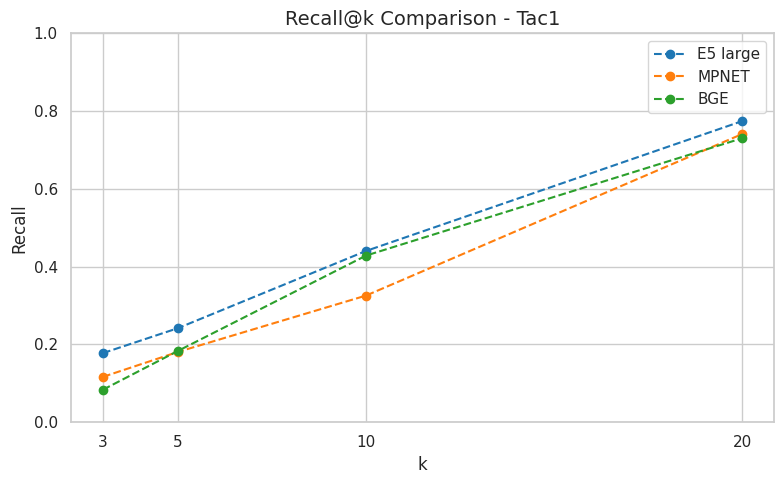

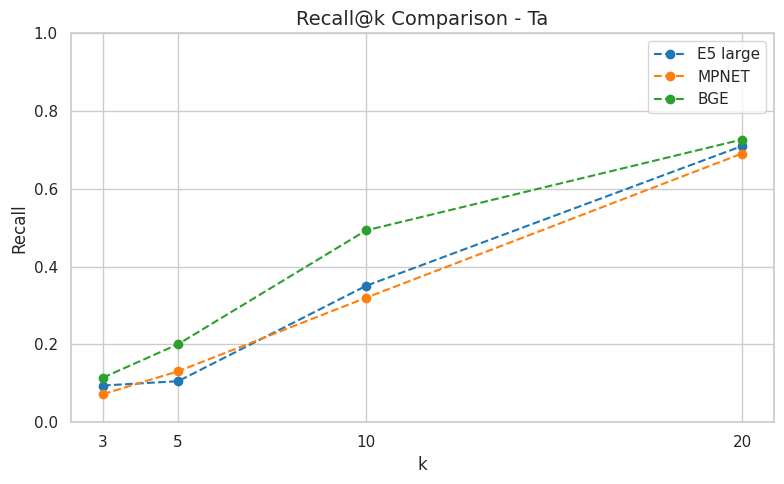

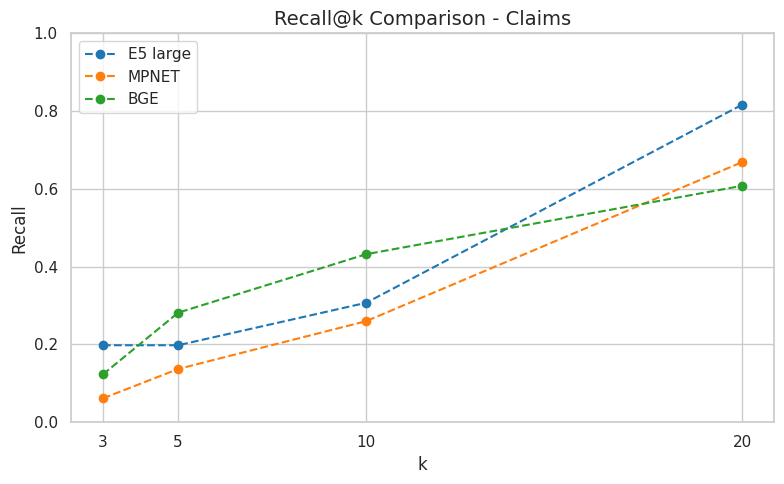

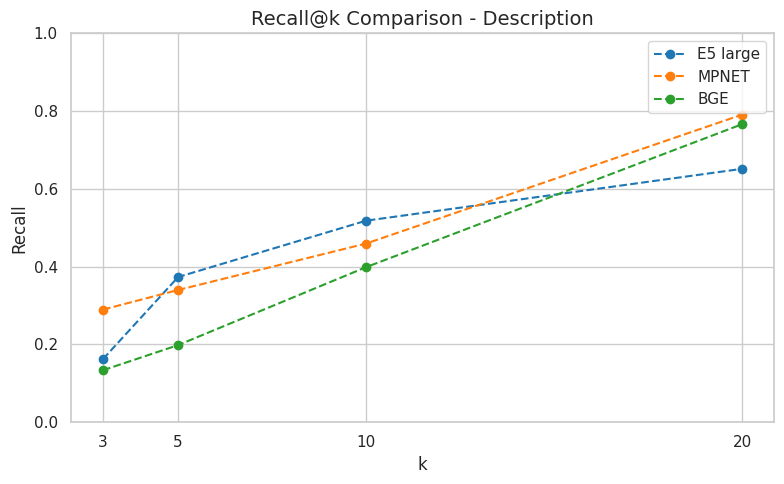

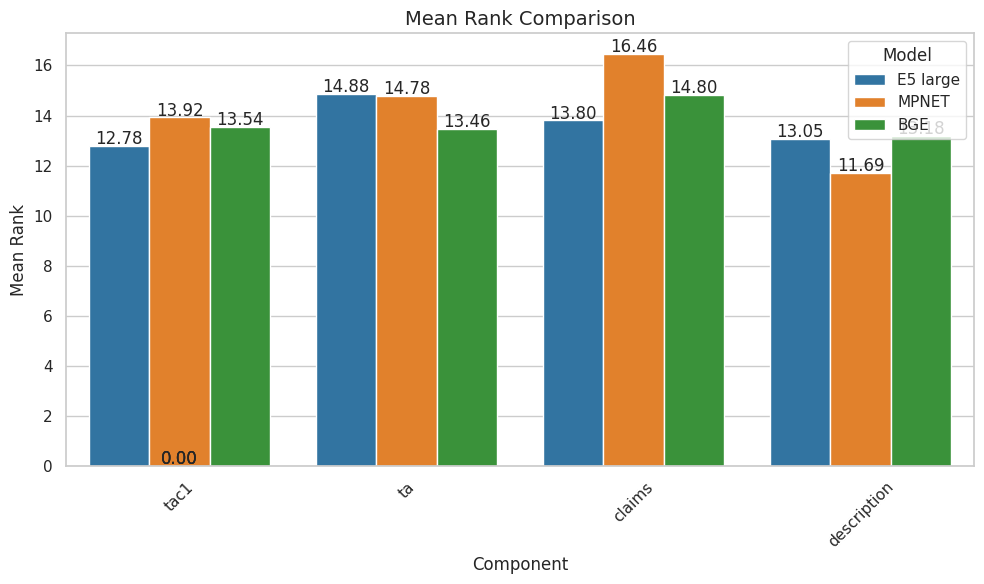

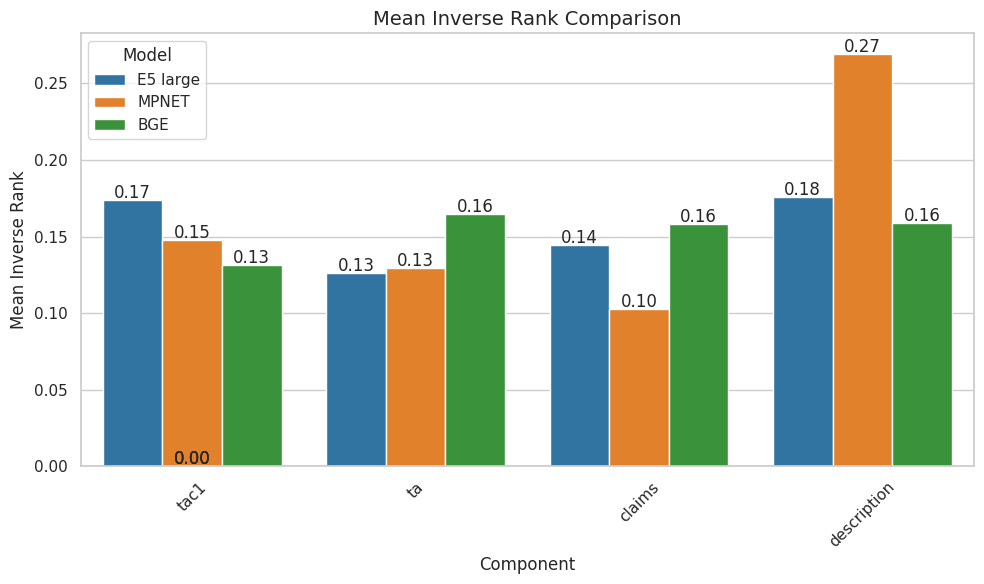

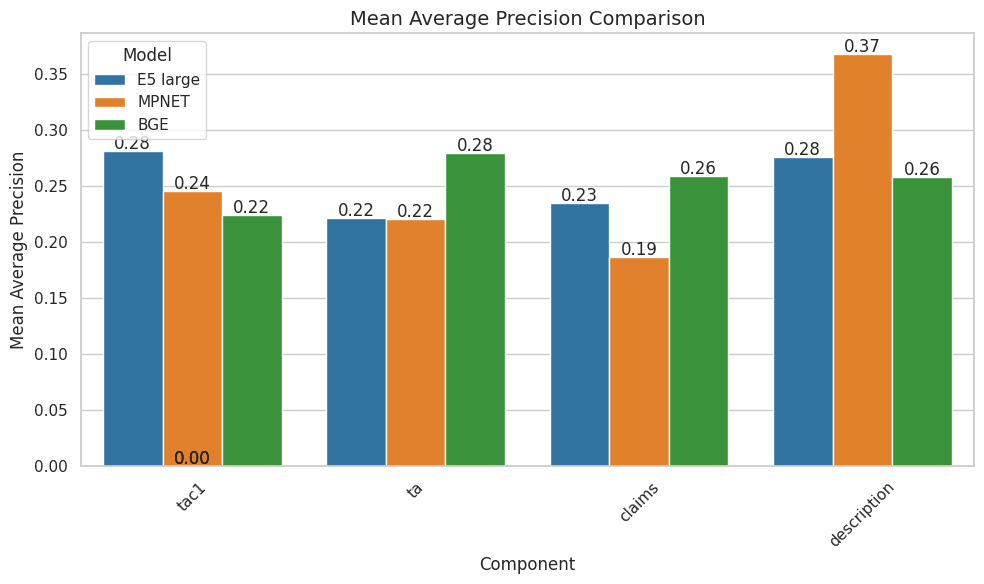

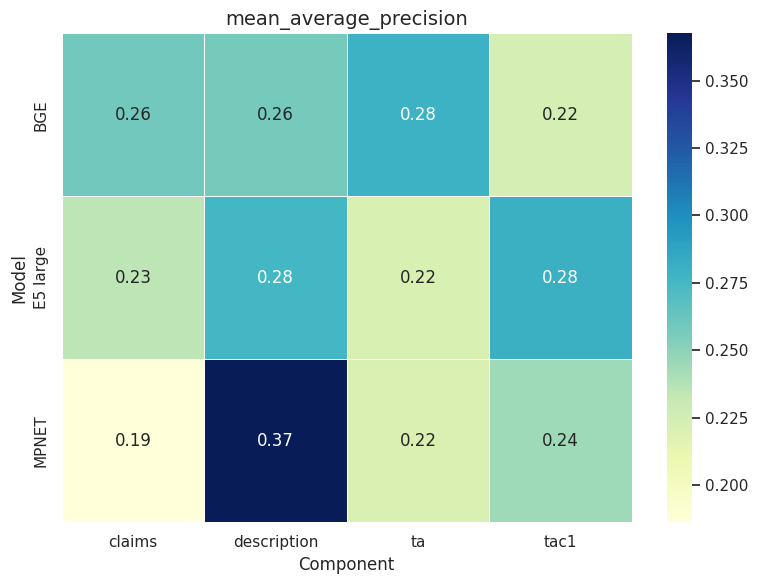

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = [
    # E5 Large
    {"Model": "E5 large", "Component": "tac1",
     "recall_at_3": 0.1778, "recall_at_5": 0.2421, "recall_at_10": 0.4405, "recall_at_20": 0.7742,
     "mean_rank": 12.7794, "mean_inv_rank": 0.1736, "mean_average_precision": 0.2808},

    {"Model": "E5 large", "Component": "ta",
     "recall_at_3": 0.0944, "recall_at_5": 0.1056, "recall_at_10": 0.3508, "recall_at_20": 0.7103,
     "mean_rank": 14.8786, "mean_inv_rank": 0.1260, "mean_average_precision": 0.2213},

    {"Model": "E5 large", "Component": "claims",
     "recall_at_3": 0.1980, "recall_at_5": 0.1980, "recall_at_10": 0.3071, "recall_at_20": 0.8163,
     "mean_rank": 13.8032, "mean_inv_rank": 0.1447, "mean_average_precision": 0.2345},

    {"Model": "E5 large", "Component": "description",
     "recall_at_3": 0.1623, "recall_at_5": 0.3734, "recall_at_10": 0.5183, "recall_at_20": 0.6516,
     "mean_rank": 13.0472, "mean_inv_rank": 0.1761, "mean_average_precision": 0.2758},

    # MPNET
    {"Model": "MPNET", "Component": "ta",
     "recall_at_3": 0.0722, "recall_at_5": 0.1310, "recall_at_10": 0.3202, "recall_at_20": 0.6909,
     "mean_rank": 14.7750, "mean_inv_rank": 0.1297, "mean_average_precision": 0.2205},

    {"Model": "MPNET", "Component": "description",
     "recall_at_3": 0.2897, "recall_at_5": 0.3401, "recall_at_10": 0.4595, "recall_at_20": 0.7909,
     "mean_rank": 11.6921, "mean_inv_rank": 0.2692, "mean_average_precision": 0.3675},

    {"Model": "MPNET", "Component": "tac1",
     "recall_at_3": 0.1167, "recall_at_5": 0.1810, "recall_at_10": 0.3258, "recall_at_20": 0.7409,
     "mean_rank": 13.9226, "mean_inv_rank": 0.1478, "mean_average_precision": 0.2450},

    {"Model": "MPNET", "Component": "claims",
     "recall_at_3": 0.0615, "recall_at_5": 0.1369, "recall_at_10": 0.2599, "recall_at_20": 0.6687,
     "mean_rank": 16.4587, "mean_inv_rank": 0.1024, "mean_average_precision": 0.1863},

    # BGE
    {"Model": "BGE", "Component": "description",
     "recall_at_3": 0.1337, "recall_at_5": 0.1984, "recall_at_10": 0.3988, "recall_at_20": 0.7663,
     "mean_rank": 13.1806, "mean_inv_rank": 0.1590, "mean_average_precision": 0.2577},

    {"Model": "BGE", "Component": "tac1",
     "recall_at_3": 0.0837, "recall_at_5": 0.1837, "recall_at_10": 0.4286, "recall_at_20": 0.7302,
     "mean_rank": 13.5444, "mean_inv_rank": 0.1313, "mean_average_precision": 0.2243},

    {"Model": "BGE", "Component": "claims",
     "recall_at_3": 0.1230, "recall_at_5": 0.2817, "recall_at_10": 0.4321, "recall_at_20": 0.6079,
     "mean_rank": 14.8040, "mean_inv_rank": 0.1580, "mean_average_precision": 0.2590},

    {"Model": "BGE", "Component": "ta",
     "recall_at_3": 0.1147, "recall_at_5": 0.2008, "recall_at_10": 0.4933, "recall_at_20": 0.7270,
     "mean_rank": 13.4619, "mean_inv_rank": 0.1645, "mean_average_precision": 0.2796},
]

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100
colors = {'E5 large': '#1f77b4', 'MPNET': '#ff7f0e', 'BGE': '#2ca02c'}

# Recall@k Line Charts
components = df['Component'].unique()
k_values = [3, 5, 10, 20]

for component in components:
    plt.figure(figsize=(8, 5))
    component_df = df[df['Component'] == component]

    for model in df['Model'].unique():
        model_df = component_df[component_df['Model'] == model]
        recalls = [model_df[f'recall_at_{k}'].values[0] for k in k_values]
        plt.plot(k_values, recalls,
                 marker='o',
                 linestyle='--',
                 color=colors[model],
                 label=model)

    plt.title(f'Recall@k Comparison - {component.capitalize()}', fontsize=14)
    plt.xlabel('k', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.xticks(k_values)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Bar Charts
metrics = ['mean_rank', 'mean_inv_rank', 'mean_average_precision']
metric_names = ['Mean Rank', 'Mean Inverse Rank', 'Mean Average Precision']

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Component', y=metric, hue='Model', data=df, palette=colors)

    plt.title(f'{metric_name} Comparison', fontsize=14)
    plt.xlabel('Component', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Model')

    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

# Heatmap for Recall@20
heatmap_df = df.pivot(index='Model', columns='Component', values='mean_average_precision')
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title('mean_average_precision', fontsize=14)
plt.xlabel('Component', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()
plt.show()


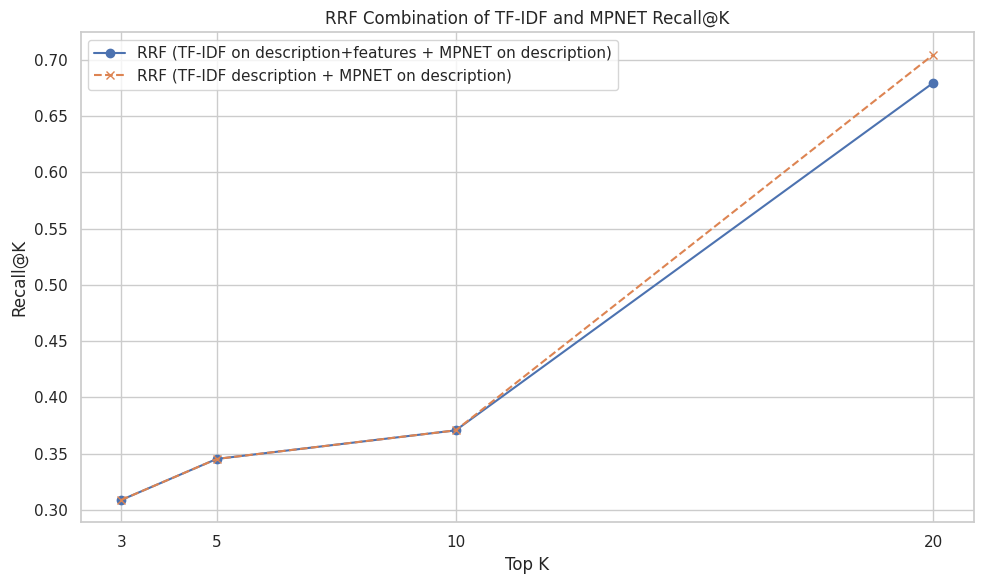

In [3]:
import matplotlib.pyplot as plt

k_values = [3, 5, 10, 20]

# Recall values for both RRF combinations
recall_rrf_tfidf_mpn_tfidf = [0.30873, 0.34524, 0.37063, 0.67976]
recall_rrf_tfidf_mpn_mpn = [0.30873, 0.34524, 0.37063, 0.70476]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(k_values, recall_rrf_tfidf_mpn_tfidf, label='RRF (TF-IDF on description+features + MPNET on description)', marker='o')
plt.plot(k_values, recall_rrf_tfidf_mpn_mpn, label='RRF (TF-IDF description + MPNET on description)', marker='x', linestyle='--')

plt.xlabel('Top K')
plt.ylabel('Recall@K')
plt.title('RRF Combination of TF-IDF and MPNET Recall@K')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
